# Лабораторна робота № 12 

**Тема.** Важкі хвости: вплив одиничних катастрофічних подій. Аналіз кризових подій із використанням Леві альфа-стабільного розподілу.

**Мета.** Навчитися використовувати розподіл Леві для диференціації флуктуацій, що виходять за межі нормального розподілу.

::: {.callout-note}
У цій лабораторній ми досліджуємо розподіл прибутковості фінансових активів і стабільність певних показників, які ми розраховуємо, опираючись на ці активи. Зокрема, ми побачимо, що більш високі моменти розподілу прибутковостей з важкими хвостами насправді дуже нестабільні, нескінченні або взагалі не визначені, і що, наприклад, одна єдина точка даних визначає більшу частину надлишкового ексцесу. Цей факт має досить драматичні наслідки, оскільки популярні моделі, такі як GARCH, базуються на можливості оцінки кінцевого значення ексцесу. Суть, яку ми хочемо донести, полягає в тому, що, не приділяючи особливої уваги повноті фінансових розподілів, не можна очікувати, що моделі будуть працювати за межами навчальної та тестувальної вибірки. Аналітики та трейдери завжди будуть дивуватись новим екстремальним подіям, що, як правило, рідко бувають позитивними.
:::

## Теоретичні відомості

### Імпортуємо необхідні бібліотеки

In [2]:
import numpy as np                 # бібліотека для роботи з масивами чисел
import matplotlib.pyplot as plt    # бібліотека для побудови графіків
import yfinance as yf              # бібліотека для зчитування фінансових даних з Yahoo Finance
import levy                        # бібліотека для роботи з альфа-стабільним розподілом Леві
import pandas as pd                # бібліотека для фільтрації даних та їх обробки
import scienceplots
from scipy.stats import norm, laplace  # бібліотека для побудови теоретичного розподілу Гауса
                                       # та Лапласа
from tqdm import tqdm                  # бібліотека для виводу шкали завантаження

%matplotlib inline

### Виконуємо налаштування рисунків

In [3]:
plt.style.use(['science', 'notebook', 'grid']) # стиль, що використовуватиметься
                                               # для виведення рисунків

params = {
    'figure.figsize': (8, 6),         # встановлюємо ширину та висоту рисунків за замовчуванням
    'font.size': 14,                  # розмір фонтів рисунку
    'lines.linewidth': 2,             # товщина ліній
    'axes.titlesize': 'small',        # розмір титулки над рисунком
    "font.family": "sans-serif",      # сімейство стилів підписів 
    "font.serif": ["Times"],          # стиль підпису
    'savefig.dpi': 300                # якість збережених зображень
}

plt.rcParams.update(params)           # оновлення стилю згідно налаштувань

### Зчитування даних 

In [4]:
df = pd.read_csv('databases\^spx_d.csv')
df.set_index('Date', inplace=True)
df.index = pd.to_datetime(df.index)
df = df[df.index >= '1950-01-01']

### Важкі хвости та Чорні понеділки

Спочатку ми розглянемо розподіл щоденних прибутковостей індексу S&P 500, починаючи з 1950 року. У клітинці нижче буде показано [Pandas dataframe](https://pandas.pydata.org/docs/user_guide/10min.html) `df`, що містить дані OHLC з файлу (ці дані були попередньо завантажені в клітинці вище).

In [5]:
df

,Open,High,Low,Close,Volume
Date,,,,,
1950-01-03,16.66,16.66,16.66,16.66,7.000000e+05
1950-01-04,16.85,16.85,16.85,16.85,1.050000e+06
1950-01-05,16.93,16.93,16.93,16.93,1.416667e+06
1950-01-06,16.98,16.98,16.98,16.98,1.116667e+06
1950-01-07,17.09,17.09,17.09,17.09,1.116667e+06
...,...,...,...,...,...
2023-04-10,4085.20,4109.50,4072.55,4109.11,1.951642e+09
2023-04-11,4110.29,4124.26,4102.61,4108.94,2.000949e+09
2023-04-12,4121.72,4134.37,4086.94,4091.95,2.249009e+09


Цей історичний ряд щоденних цін містить \~ 18527 торгових днів. Замість того, щоб дивитися безпосередньо на ціни, ми розглянемо щоденні [*log*-прибутковості](https://lucaslouca.com/Why-Use-Logarithmic-Returns-In-Time-Series-Modelling/) індексу S&P 500. Пам'ятайте, що логарифмічна прибутковість $r_t$ визначається як логарифм відношення між цінами закриття $p_t$ у теперішній момент часу та попередній, $p_{t-1}$:

$$
r_t = \log(\frac{p_t}{p_{t-1}})
$$

Логарифмічні прибутковості характеризуються симетрією, тобто якщо в один день індекс втрачає $r_t = -0.1$, а на наступний день індекс набирає $r_{t+1} = +0.1$, індекс знову досягає початкової ціни. Зі звичайними прибутковостями, спочатку втративши $10\%$, а потім знову набравши $10\%$, ви не повернетесь до початкової ціни. Ми зберігаємо прибутковості в новому фреймі даних `lr`:

In [8]:
lr = np.log(df['Close']).diff().dropna()

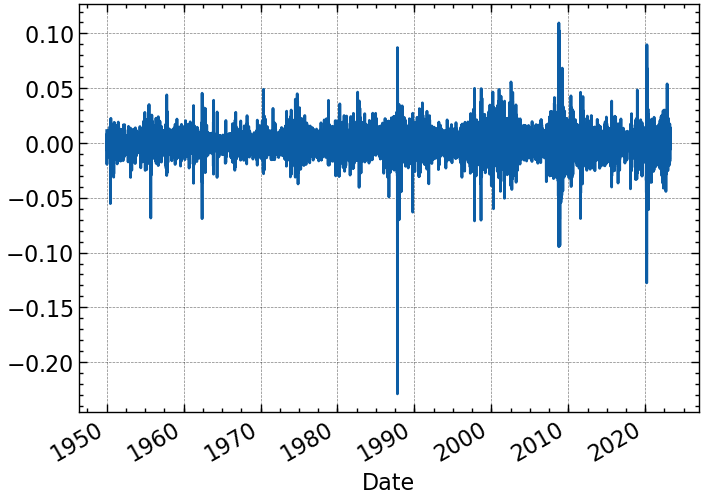

In [9]:
lr.plot()
plt.show();

Використовуючи вбудовані функції Pandas та Numpy, тепер ми можемо подивитись на найгірше щоденнє значення прибутковостей. Ми виявляємо, що найгірше значення становило $-0.229$, що відповідає $-22.9\%$, і що це сталося в понеділок, 19 жовтня 1987 року --- так званий [*Чорний понеділок*](https://en.wikipedia.org/wiki/Black_Monday_(1987)).

In [10]:
# найгірший щоденні прибутковості від закриття до закриття
lr.min()

-0.2289972265656708

In [11]:
# відповідні арифметичні прибутковості
np.exp(lr.min()) - 1

-0.20466926070038938

In [12]:
# індекс найгіршого значення
np.argmin(lr)

9583

In [13]:
df.iloc[9583:9585]

,Open,High,Low,Close,Volume
Date,,,,,
1987-10-16,298.08,298.92,281.52,282.70,188055556.0
1987-10-19,282.70,282.70,224.83,224.84,335722222.0


Далі ми будуємо графік вибіркового розподілу щоденних логарифмічних прибутковостей, що демонструє нам, як часто ми спостерігаємо щоденні прибутковості певного знака та величини. Зверніть увагу, що ми встановили логарифмічне масштабування для вісі Оy, щоб мати краще представлення про хвости розподілу, тобто дуже великі, але рідкісні негативні та позитивні прибутковості --- крахи та підйоми:

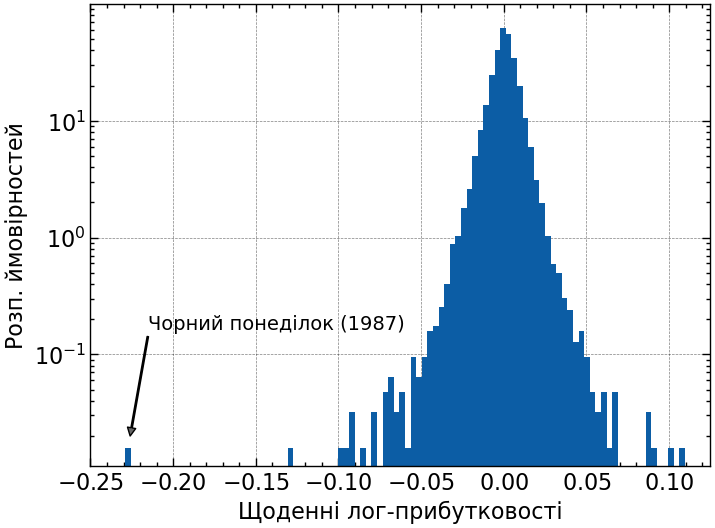

In [14]:
plt.figure()
plt.hist(lr, 100, density=True)
plt.yscale('log')
plt.ylabel('Розп. ймовірностей')
plt.xlabel('Щоденні лог-прибутковості')
plt.xlim([-0.25, 0.125])
plt.ylim([0.011, 99])
plt.annotate('Чорний понеділок (1987)', [-0.226, 0.02], xytext=[-0.215, 0.15],
             arrowprops=dict(facecolor='0.4', width=1, headwidth=6, headlength=6),
             ha='left', va='bottom');
plt.show();

Як ми можемо описати погіршення розподілу прибутковості? За допомогою [логарифмічного масштабування](https://en.wikipedia.org/wiki/Logarithmic_scale) осі Oy, щоб експоненціальний спад виглядав лінійно, тому ми могли би запідозрити, що при малих абсолютних значеннях прибутковості розподіл зменшується експоненціально, але в міру збільшення абсолютних значень прибутковостей ми все більше і більше відхиляємося від початкового нахилу. Насправді, ми можемо показати, що ні розповсюдженний [розподіл Гауса](https://en.wikipedia.org/wiki/Normal_distribution) (також званий *нормальним* розподілом), ні [розподіл Лапласа](https://en.wikipedia.org/wiki/Laplace_distribution) з його експоненціальним спадом з обох сторін точно не можуть змоделювати розподіл прибутковостей S&P 500. Як розподіл Гауса, так і розподіл Лапласа недооцінюють ймовірність екстремальних подій --- підйомів та крахів:

In [15]:
# підганяємо розподіл Гауса та Лапласа під дані
norm_loc, norm_scale = norm.fit(lr)
laplace_loc, laplace_scale = laplace.fit(lr)

# генеруємо значення (x,y) з використанням отриманих параметрів розподілів
x_fit = np.linspace(-0.25, 0.125, 1000)
y_fit_norm = norm(loc=norm_loc, scale=norm_scale).pdf(x_fit)
y_fit_laplace = laplace(loc=laplace_loc, scale=laplace_scale).pdf(x_fit)

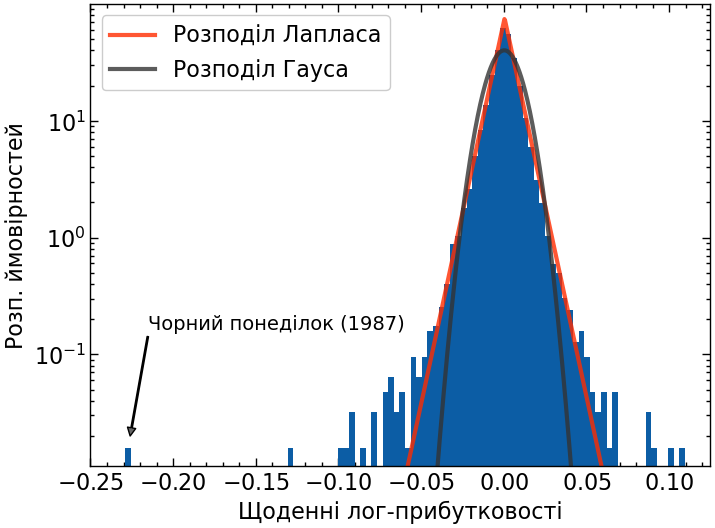

In [16]:
plt.figure()
plt.hist(lr, 100, density=True)
plt.plot(x_fit, y_fit_laplace, lw=3, c='C3', alpha=0.8, label='Розподіл Лапласа')
plt.plot(x_fit, y_fit_norm, lw=3, c='0.2', alpha=0.8, label='Розподіл Гауса')
plt.yscale('log')
plt.ylabel('Розп. ймовірностей')
plt.xlabel('Щоденні лог-прибутковості')
plt.xlim([-0.25, 0.125])
plt.ylim([0.011, 99])
plt.legend()

plt.annotate('Чорний понеділок (1987)', [-0.226, 0.02], xytext=[-0.215, 0.15],
             arrowprops=dict(facecolor='0.4', width=1, headwidth=6, headlength=6),
             ha='left', va='bottom');

plt.show();

### Відхилення в 23 сигма

Як ми можемо бачити вище, як розподіл Гауса, так і розподіл Лапласа різко недооцінюють ймовірність дуже волатильної динаміки! Часто зазначають, що трапилась "[3-сигма](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule) подія на ринку" або щось подібне, тому що багатьом людям подобається оцінювати індивідуальні прибутковості по [стандартному відхиленню](https://en.wikipedia.org/wiki/Standard_deviation) (зване "сигмою") підібраного гаусового розподілу. Однак, якщо Розподіл Гауса взагалі не відповідає розподілу вибірки, як у нашому випадку, оцінка краху в одиницях "сигма" може ввести в оману! Щоб показати це, ми спочатку перевіримо, на скільки сигм ринок змістився в Чорний понеділок 1987 року:

In [17]:
np.abs(np.min(lr))/np.std(lr, ddof=1)

22.969393251617504

Виходячи з розподілу по Гауса, Чорний понеділок був би подією з "23 сигмами"! Тепер Розподіл Гауса чітко говорить нам, як часто X-сигма подія має відбуватися:

- 1-сигма: прибл. 1 з 3 днів
- 2-сигма: прибл. 1 з 22 днів
- 3-сигма: прибл. 1 з 370 днів

...

Ми можемо розширити цю таблицю, попрацювавши з [функцією кумулятивного розподілу](https://en.wikipedia.org/wiki/Cumulative_distribution_function), тісно пов'язана з [функцією виживання](https://en.wikipedia.org/wiki/Survival_function), і перемістивши обчислення в логарифмічний простір для чисельної стабільності, як демонструють наступні комірки коду:

In [18]:
# у середньому, як багато днів між 1-сигма подіями?
1/(2*(1. - norm.cdf(1.)))

3.1514871875343764

In [19]:
# у середньому, як багато днів між 2-сигма подіями?
1/(2*(1. - norm.cdf(2.)))

21.97789450799283

In [20]:
# у середньому, як багато днів між 3-сигма подіями?
1/(2*(1. - norm.cdf(3.)))

370.3983473449564

In [21]:
# те саме, що й вище, але із використанням функції виживання
1/(2*norm.sf(3.))

370.3983473449592

In [22]:
# те саме, що й вище, але із використанням логарифмічної функції функції виживання для чисельної стабільності
np.exp(-norm.logsf(3.) - np.log(2.))

370.398347344959

In [23]:
# те саме, що й вище, але із використанням логарифму з основою 10 для замість натурального логарифму для кращої інтерпретації
10**(-norm.logsf(3.)/np.log(10) - np.log10(2.))

370.3983473449588

In [24]:
# як багато днів (log10 значення) між 23-сигма подіями, в середньому?
(-norm.logsf(23.)/np.log(10) - np.log10(2.))

116.33149536636726

Щоб отримати додаткову інформацію про частоту екстремальних прибутковостей, ми можемо навіть створити невеликий [інтерактивний віджет](https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Basics.html) за допомогою повзунка, який вказує кількість "сигм", а текст поруч із ним показує середню кількість днів між двома такими екстремальними подіями:

In [25]:
from ipywidgets import IntSlider, interact

def years_between(X):
    log10_days = (-norm.logsf(X)/np.log(10) - np.log10(2.))
    days = int(10**log10_days)
    return f'У сереньому, між двома X-сигма подіями, варто очікувати {days} дні(в), (день).'

interact(years_between, X=IntSlider(min=1, max=23, step=1, value=1));

interactive(children=(IntSlider(value=1, description='X', max=23, min=1), Output()), _dom_classes=('widget-int…

In [26]:
np.log10(float(214533622638557983431869220329015643677794364342592664885632499326649056583365324378194575664549945880382591666749440))

116.33149536636726

Ви бачите, що при переміщенні повзунка вправо кількість днів або років між двома наступними "X-сигма" подіями швидко наростає. Наша таблиця тепер виглядає наступним чином:

- 1-сигма: прибл. 1 з 3 днів
- 2-сигма: прибл. 1 з 22 днів
- 3-сигма: прибл. 1 з 370 днів

...   

- 23-сигма: приблизно 1 з $10^{116}$ днів (!!!)

Внесемо ясність: виходячи з розподілу Гауса, щоденні втрати Чорної п'ятниці 1987 року повинні бути подією, яку ми очікуємо раз на $10^{116}$ днів. Це число в значній мірі незбагненно велике. Якби S&P 500 почав торгуватися відразу після [народження Всесвіту](https://en.wikipedia.org/wiki/Age_of_the_universe), це становило б лише $10^{13}$ торгових днів. Через $10^{116} $ днів усі зірки у Всесвіті давно згорять, навіть усі [чорні діри випаруються](https://en.wikipedia.org/wiki/Future_of_an_expanding_universe#Dark_Era_and_Photon_Age) і Всесвіт стане темним і порожнім місцем. Тож або ми повинні бути дуже щасливі, що єдина очікувана Чорна п'ятниця в історії та майбутньому Всесвіту позаду, або ви дійсно ніколи не повинні використовувати Розподіл Гауса для моделювання прибутковості акцій! Незалежно від ринку та деталей, якщо хтось говорить про події з 10 сигмами або 23 сигмами, він, безумовно, використовує неправильну модель, оскільки шанс спостерігати таку подію в нашому житті незначний.

Отже, виникає питання: Як ми справляємось із такими екстремальними значеннями? Чи слід позначати їх як [викиди](https://en.wikipedia.org/wiki/Outlier) або артефакти, щоб наші фінансові моделі краще описували більшість значень? Звичайно, ні, оскільки результат наших інвестицій може критично залежати не від більшості менших прибутковостей, а саме від таких екстремальних подій! Далі ми познайомимося з підходом, який може пояснити та екстраполювати за межі екстремальних подій, таких як Чорний понеділок. Але ми також побачимо, що не всі способи врахування важких хвостів розподілів працюють добре, оскільки деякі моделі, такі як [GARCH](https://en.wikipedia.org/wiki/Autoregressive_conditional_heteroskedasticity) може заколисати нас помилковим почуттям безпеки, коли ми завжди беремо до уваги минулі екстремальні події, але завжди дивуємося новим.

### Статистика степеневого розподілу

Тепер, коли ми знаємо, що розподіл Гауса не є хорошим вибором, який тип розподілу насправді може описати частоту екстремальних подій, які струшують S&P 500? Частота екстремально позитивні та негативні прибутковості асиметричні для більшості фінансових активів, оскільки крахи, як правило, більш сильні, ніж підйоми. Ось чому нижче ми зосередимося на лівому (негативному) хвості розподілу прибутковостей.

Оскільки нас цікавлять лише екстремальні події, ми розглянемо лише ті прибутковості, які менше $-0.03$ (приблизно три стандартних відхилення від середнього значення). Нижче ми візуалізуємо ці екстремально негативні показники прибутковостей в [логарифмічному масштабі](https://en.wikipedia.org/wiki/Log%E2%80%93log_plot) (тут ми використовуємо абсолютні значення негативних прибутковостей). Як вісь Oy (яка показує частоту логарифмічних прибутковостей), так і вісь Ox (яка показує величину логарифмічних прибутковостей) масштабуються логарифмічно:

In [27]:
# хвіст починається приблизно при трьох стандартних відхиленнях від середнього
np.mean(lr) - 3*np.std(lr)

-0.029610514264246313

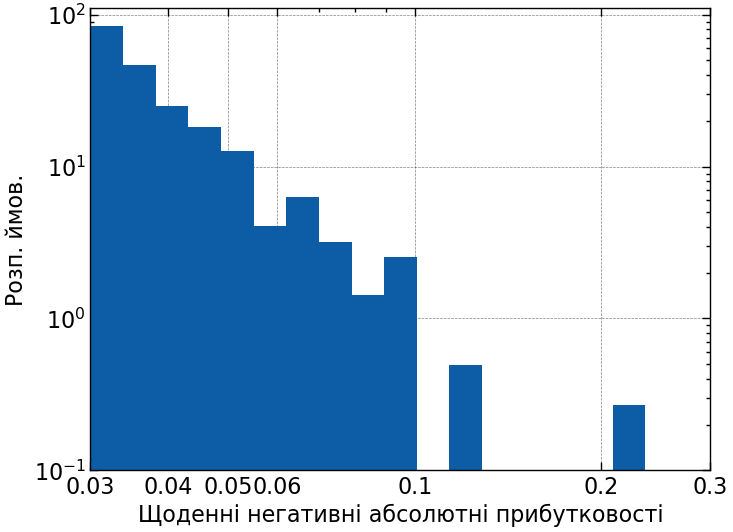

In [28]:
neg_lr = -lr[lr < 0]

plt.figure()
hist = plt.hist(neg_lr, bins=np.logspace(np.log10(0.03),np.log10(0.3), 20), density=True)
plt.yscale("log")
plt.xscale("log")
plt.ylabel('Розп. ймов.')
plt.xlabel('Щоденні негативні абсолютні прибутковості')

plt.ylim([0.1, 110])
plt.xlim([0.03, 0.3])
plt.xticks([0.03, 0.04, 0.05, 0.06, 0.1, 0.2, 0.3], [0.03, 0.04, 0.05, 0.06, 0.1, 0.2, 0.3])
plt.show();

Як ми бачимо, ця гістограма екстремальних абсолютних прибутків зменшується приблизно лінійно при логарифмічному масштабуванні. Щоразу, коли ви виявляєте пряму лінію на логарифмічному графіку, це вказує на так званий [степеневий розподіл](https://en.wikipedia.org/wiki/Power_law). Степеневе співвідношення ймовірності спостереження великих абсолютних логарифмічних прибутковостей задається у вигляді:

$$
p(|r_t|) = c \cdot |r_t|^{-\alpha}
$$

Константа $c$ на даний момент нас не надто турбує, вона просто гарантує, що ліва частина рівняння належним чином нормалізована, але показник $\alpha $ представляє для найбільший інтерес, оскільки він говорить нам, як працює степеневий закон. Якщо ви знаєте частоту даних абсолютних логарифмічних прибутковостей, то степеневий закон підкаже вам, у скільки разів менш імовірними були б логарифмічні прибутковості подвоєного розміру:

$$
p(2 \cdot |r_t|) = c \cdot (2 \cdot |r_t|)^{-\alpha} = 2^{-\alpha} \cdot c \cdot |r_t|^{-\alpha} = 2^{-\alpha} \cdot p(|r_t|)
$$

або простіше:

$$
\frac{p(2 \cdot |r_t|)}{p(|r_t|)} = \frac{1}{2^{\alpha}}
$$

Для $\alpha = 0 $ всі прибутковості однаково ймовірні, для $ \alpha = 2 $ подвоєння прибутковостей робить їх у 4 рази менш імовірними. Оскільки це правило подвоєння вгору або вниз не залежить від значення самого $\left| r_t \right|$, але працює для всіх значень $\left| r_t \right|$. Степеневе співвідношення також називаються "безмасштабним" або [масштабо-інваріантним](https://en.wikipedia.org/wiki/Scale_invariance).

Як щодо показника $\alpha$ для наших надзвичайно негативних логарифмічних прибутковостей S&P 500? Ми можемо легко оцінити його за даними, але є деякі тонкощі у правильному розбитті вищезазначеної гістограми, які можуть вплинути на нашу оцінку (див., наприклад, [White et al. (2008)](https://esajournals.onlinelibrary.wiley.com/doi/10.1890/07-1288.1)). Щоб обійти ці проблеми з розбиттям, ми можемо замість цього оцінити степенний показник [кумулятивної гістограми](https://en.wikipedia.org/wiki/Histogram#Cumulative_histogram) логарифмічних прибутковостей, а потім відняти одиницю від отриманого нахилу:

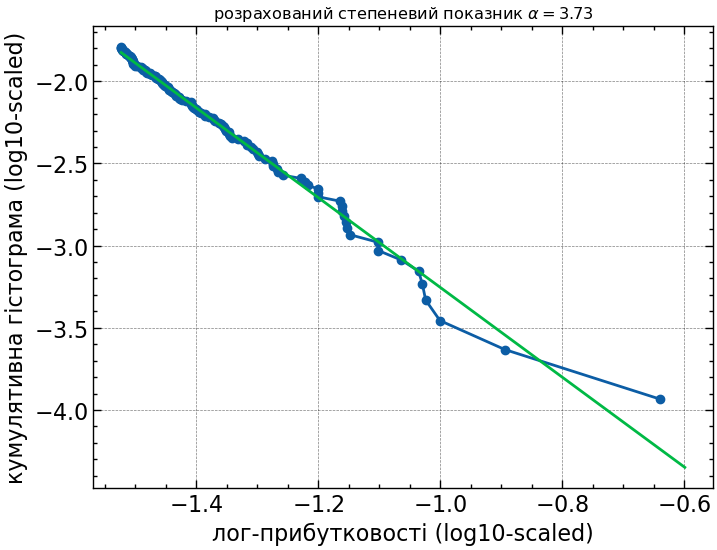

In [29]:
# підганяємо лінію регресії до кумулятивної гістограми (log10 для ймовірності) vs. лог-прибутковості (log10)
sorted_neg_lr = np.sort(neg_lr.values)
cumulative_probability = np.linspace(1, 0, len(sorted_neg_lr)+1)[:-1]

x_min = 0.03
mask = sorted_neg_lr >= x_min
m, b = np.polyfit(np.log10(sorted_neg_lr[mask]), np.log10(cumulative_probability[mask]), 1)
alpha = -(m - 1)

plt.figure()
plt.plot(np.log10(sorted_neg_lr[mask]), np.log10(cumulative_probability[mask]))
plt.scatter(np.log10(sorted_neg_lr[mask]), np.log10(cumulative_probability[mask]), label='sample data')

x_fit = np.linspace(np.log10(x_min), np.log10(1.1*np.max(neg_lr)), 100)
y_fit = m*x_fit + b

plt.plot(x_fit, y_fit, label='степенева підгонка')
plt.title(f'розрахований степеневий показник $\\alpha={alpha:.2f}$')
plt.xlabel('лог-прибутковості (log10-scaled)')
plt.ylabel('кумулятивна гістограма (log10-scaled)')
plt.show();

Виходячи з цієї оцінки, ми отримуємо степеневої показник, рівний $\alpha \approx 3.7$. Якщо ми побудуємо гістограму наших надзвичайно негативних логарифмічних прибутковостей, то побачимо, що вона добре відображає зниження ймовірності, оскільки масштаб збоїв збільшується. Однак цей степеневий показник все ще недооцінює ймовірність настання чергового "Чорного понеділка", оскільки лінія відповідності не ідеально підходить до цієї крайньої точки. Якби ми захотіли створити ще більш консервативну модель екстремальних подій, нам потрібно було б вручну ще більше зменшити значення $ \alpha $, щоб врахувати більшу ймовірність настання чорних понеділків за рахунок втрати точності підгонки для менших збоїв. Це перший раз, коли ми можемо побачити, як одна точка даних впливає на наші рішення щодо моделювання. На даний момент ми будемо довіряти оцінці параметра і погодимося з оцінкою $\alpha=3.7$.

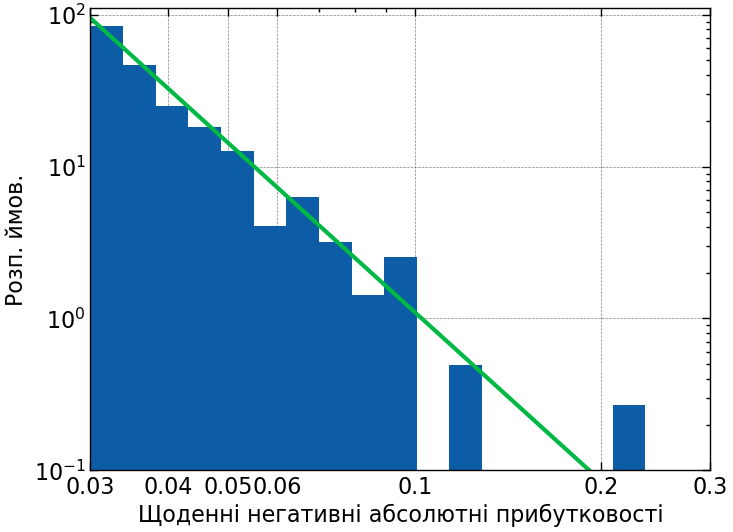

In [30]:
neg_lr = -lr[lr < 0]

plt.figure()
hist = plt.hist(neg_lr, bins=np.logspace(np.log10(0.03),np.log10(0.3), 20), density=True)
plt.yscale("log")
plt.xscale("log")
plt.ylabel('Розп. ймов.')
plt.xlabel('Щоденні негативні абсолютні прибутковості')
plt.ylim([0.1, 110]);
plt.xlim([0.03, 0.3])
plt.xticks([0.03, 0.04, 0.05, 0.06, 0.1, 0.2, 0.3], [0.03, 0.04, 0.05, 0.06, 0.1, 0.2, 0.3]);

x_fit = np.logspace(np.log10(0.03),np.log10(0.3), 100)
y_fit = 0.00022*(x_fit**-3.7)

plt.plot(x_fit, y_fit, lw=3)
plt.show();

Ми можемо використовувати цей степеневий закон, щоб екстраполювати, як часто ми очікуємо настання чорного понеділка (або "події з 23 сигмами") у довгостроковій перспективі. Виходячи з наявних у нас даних, ми можемо оцінити, що ймовірність спостереження зниження на $-0.03$ або гірше становить близько $1.6\%$. Слідуючи нашій степеневій кривій, зниження чорного понеділка на $-0.229$, таким чином, відбувалося б із частотою $\left(\frac{0.229}{0.03}\right)^{-3.7} \approx \frac{1}{1845}$. Так само часто, як зниження на $ -0.03$, яке ми спостерігаємо приблизно раз на три місяці. Це означає, що, виходячи з нашої степеневої кривої, очікується, що чорні понеділки, подібні до 1987 року, траплятимуться приблизно раз на 450 років (див. код нижче).

In [29]:
# як часто ринок знижується більш ніж на -0.03
(neg_lr > 0.03).mean()

0.016091417910447763

In [30]:
# у середньому, як багато днів між цима трьома подіями
1./(neg_lr > 0.03).mean()

62.144927536231876

In [31]:
# у скільки разів менше відбувається подій "Чорного понеділка" в порівнянні зі зниженням на -0.03?
(np.max(neg_lr)/0.03)**3.7

1845.1139014672306

In [32]:
np.max(neg_lr)

0.2289972265656708

In [33]:
# скільки років пройшло між двома подіями "Чорного понеділка",
# виходячи з припущення, що подія -0.03 відбувається один раз у 63 дня?
(1./((1/62)*1/1845))/252

453.92857142857144

Якби ми включили більше даних, що містять інші приклади екстремальних подій, наприклад, з [Великої депресії](https://en.wikipedia.org/wiki/Great_Depression), ця оцінка може стати ще меншою. Аналогічно, якби ми скоригували степеневий показник так, щоб він був більш консервативним, ніж передбачає наш простий метод оцінки, ми також отримали б коротший період. Хоча 460 років все ще є дуже великим періодом, це набагато більш реалістична оцінка порівняно з $10^{114}$ роками, які ми отримали, використовуючи розподіл Гауса. Однією з переваг степеневої моделі є її здатність до екстраполяції: використовуючи степеневу оцінку $\alpha$ та частоту менших прибутковостей, щодо яких ми маємо достовірні дані, ми можемо оцінити частоту майбутніх серйозних збоїв, щодо яких ми ще не отримали жодних даних. Ще про одну перевагу оцінки $\alpha$ ми розглянемо далі.

::: {.callout-tip}
## ПРИМІТКА

Не існує такого поняття, як "подія з 10 сигмами"! Справжня подія з 10 сигмами настільки неймовірно рідкісна, що пережити її протягом нашого життя --- мізерно мало. Екстремальні події, безумовно, трапляються, але вони не можуть бути описані за допомогою "сигм", їх потрібно враховувати і екстраполювати з використанням степеневих законів. Завжди будьте обережні, коли аналітики виправдовують себе за те, що вони не були готові до "події з 10 сигмами", оскільки це вказує на те, що їх моделі ризиків вкрай недосконалі.
:::

### Статистичні моменти під впливом важких хвостів

Чому все це так важливо? Степенневий показник $\alpha$ насправді багато говорить нам про стабільність і збіжність [моментів розподілу ймовірностей](https://en.wikipedia.org/wiki/Moment_(mathematics)), і це, в свою чергу, має значення для деяких найбільш часто використовуваних моделей у фінансах. Перші чотири центральні моменти --- це:

- **[Середнє](https://en.wikipedia.org/wiki/Expected_value)**: очікуване значення розподілу
- **[Дисперсія](https://en.wikipedia.org/wiki/Variance)**: Квадрат стандартного відхилення, який часто використовується для оцінки волатильності на основі розподілу прибутковості.
- **[Асиметрія](https://en.wikipedia.org/wiki/Skewness)**: вимірює зміщення розподілу. Розподіл прибутковостей, як правило, має негативну асиметрію, оскільки збої є більш стрімкими, ніж підйоми.
- **[Ексцес](https://en.wikipedia.org/wiki/Kurtosis)**: вимірює тяжкість хвостів розподілу. Розподіли прибутковостей зазвичай мають ексцес більший ніж у розподілі Гауса, тобто екстремальні події відбуваються частіше, ніж очікувалося в гаусовій моделі.

Ексцес Гаусового розподілу дорівнює 3 (використовуючи визначення Пірсона, з визначенням Фішера [надлишкового ексцесу](https://en.wikipedia.org/wiki/Kurtosis#Excess_kurtosis) це 0), але наша вибірка щоденних логарифмічних прибутковостей S&P 500 має ексцес $28.6$, що знову вказує на те, що екстремальні події набагато більш вірогідні, що суперечить Гаусовому розподілу.

In [34]:
# обчислюємо ексцес лог-прибутковостей
from scipy.stats import kurtosis

kurtosis(lr, fisher=False, bias=False)

28.610931957080663

Тепер ми дійшли до того моменту, коли ми могли б запитати: наскільки сильно одна точка впливає на нашу оцінку ексцесу? Якщо ми перерахуємо ексцес всіх щоденних прибутків S&P 500 з 1950 року і виключимо тільки чорний понеділок 1987 року, ми отримаємо значення $14.3$, майже половину від значення, яке ми отримуємо, коли використовуємо всі значення! Видалення подальших найгірших днів, звичайно, ще більше зменшує ексцес, але ефект значно менший.

In [35]:
# обчислюємо ексцес лог-прибутковостей після видалення Чорного понеділка 1987
kurtosis(lr[lr > np.min(lr)], fisher=False, bias=False)

14.3083633314701

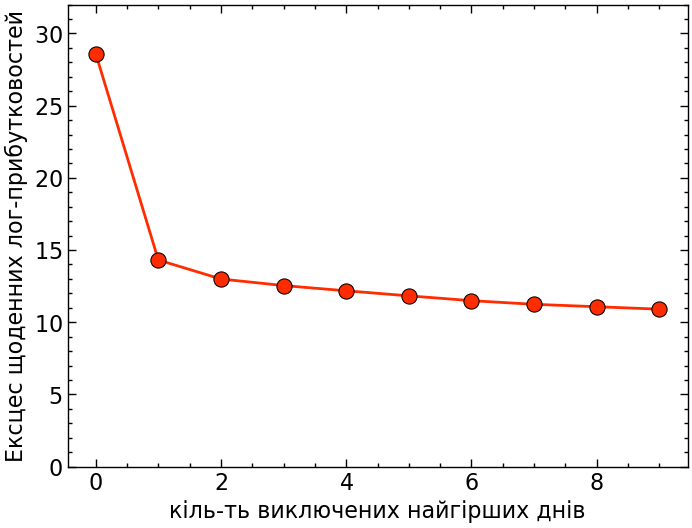

In [36]:
lr_sorted = lr.sort_values()
kurt = [kurtosis(lr_sorted.iloc[i:], fisher=False, bias=False) for i in range(10)]

plt.figure()
plt.plot(np.arange(10), kurt, c='C3', lw=2, zorder=2)
plt.scatter(np.arange(10), kurt, s=120, lw=0.75, edgecolor='k', facecolor='C3', zorder=3)
plt.grid()
plt.xlabel('кіль-ть виключених найгірших днів')
plt.ylabel('Ексцес щоденних лог-прибутковостей')
plt.ylim([0, 32])
plt.show();

Більш радикальний погляд на цю проблему досягається, якщо ми будуємо графік ексцесу в покроковому режимі, тобто для кожного дня ми будуємо розрахунковий ексцес, використовуючи всі минулі логарифмічні дані до цього моменту часу. Як ви можете бачити нижче, до "Чорного понеділка" ексцес ніколи не перевищував $15$, проте навіть через 35 років після "Чорного понеділка" ексцес ще не "оговтався" від цієї події і залишається на позначці 30. Чи означає це, що ми повинні просто ігнорувати Чорний понеділок як викид і продовжувати використовувати нашу "чисту" оцінку в $14.6$? Ні, точно ні! Як ми побачимо незабаром, ми скоріше повинні запитати себе, чи є сенс у тому, щоб оцінювати ексцес!

In [37]:
kurt = [kurtosis(lr.iloc[:i], fisher=False, bias=False) for i in range(1000, len(lr))]

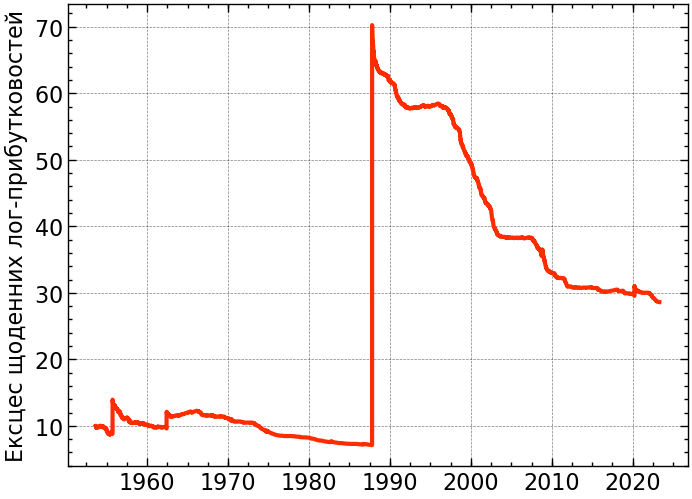

In [38]:
plt.figure()
plt.plot(lr.index[1000:], kurt, c='C3', lw=3, zorder=2)
plt.ylabel('Ексцес щоденних лог-прибутковостей')
plt.show();

Той факт, що одна точка даних може настільки сильно змінити нашу оцінку ексцесу, і, схоже, вона більше не сходиться, коли додаються нові точки даних, є чітким свідченням того, що ексцес базового розподілу ймовірностей насправді нескінченний! Проблема полягає в тому, що для кінцевої вибірки даних (а всі набори даних скінченні) ми завжди зможемо оцінити скінчене значення ексцесу. `scipy.stats.kurtosis` не може повернути $\infty$, він завжди повідомлятиме про скінченний ексцес *вибірки*. Але ця кінцева оцінка не допоможе нам нічого сказати про майбутню поведінку ринку, оскільки ексцес продовжуватиме переходити до ще більших значень до наступного чорного понеділка, іншого чорного вівторка ... у більш-менш віддаленому майбутньому.

Однак опис частоти екстремальних подій згідно степеневого закону, який ми представили вище, може допомогти нам вирішити, чи є ексцес кінцевим, так що, переглянувши достатню кількість точок даних, ми зможемо вирішити, чи слід прийняти той факт, що ексцес не піддається оцінці і справді нескінченний. Щоб побачити це, нам потрібно ввести ще один розподіл ймовірностей, [t-розподіл Стьюдента](https://en.wikipedia.org/wiki/Student%27s_t-distribution). Це колоколообразний симетричний розподіл зі степеневими хвостами. Його додатковий параметр $\nu$ визначає показник степеневого закону $\alpha=(\nu+1)$. Нижче ми підганяємо t-розподіл до наших логарифмічних прибутковостей S&P 500, зберігаючи при цьому степеневий показник $\alpha=3.7$ (відповідний $\nu = 2.7$), який ми підганяли раніше:

In [39]:
from scipy.stats import t

fit_params = t.fit(lr, fix_df=2.7)

x_fit = np.linspace(-0.25, 0.125, 1000)
y_fit_t = t(*fit_params).pdf(x_fit)

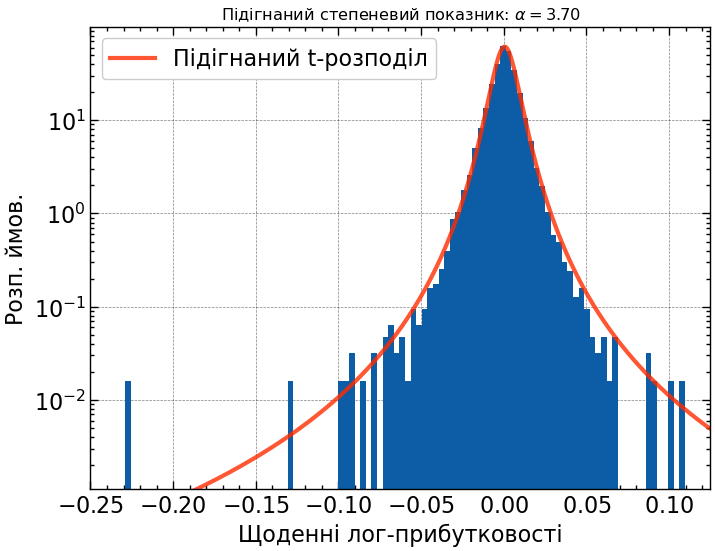

In [40]:
plt.figure()
plt.hist(lr, 100, density=True)
plt.plot(x_fit, y_fit_t, lw=3, c='C3', alpha=0.8, label="Підігнаний t-розподіл")
plt.yscale('log')
plt.ylabel('Розп. ймов.')
plt.xlabel('Щоденні лог-прибутковості')
plt.xlim([-0.25, 0.125])
plt.ylim([0.0011, 99])
plt.legend()

plt.title(f'Підігнаний степеневий показник: $\\alpha = {(fit_params[0]+1):.2f}$')
plt.show();

Звичайно, можна поставити під сумнів, чи дійсно t-розподіл Стьюдента добре відповідає нашим логарифмічним прибутковостям, оскільки він переоцінює частоту абсолютних прибутковостей і все ще недооцінює ймовірність настання Чорного понеділка. На даний момент ми ігноруємо ці деталі та зосереджуємось на ексцесі t-розподілу Стьюдента та зв'язку зі степеневим показником $\alpha$:

- $\text{Kurt} = \frac{6}{\nu-4} + 3~$ для $~\nu > 4~$ або $~\alpha > 5$
- $\text{Kurt} = \infty~~~~~~~~~~\,$ для $~2 < \nu \leq 4~$ або $~3 < \alpha \leq 5$
- інакше невизначено

Це підтверджує наше початкове припущення про те, що при степеневому показнику, рівному $\alpha \approx 3.7$, ексцес дійсно нескінченний, і немає сенсу оцінювати його по скінченій вибірці, оскільки оціночне значення буде зберігатися тільки до наступної екстремальної події, яка підштовхне його ще вище. Ми можемо легко змоделювати цей ефект, витягуючи випадкові вибірки з t-розподілів Стьюдента з різними степеневими показниками, які відповідають трьом режимам, зазначеним вище. Нижче ми витягуємо 100 000 випадкових значень з t-розподілів з $\alpha = 2$, $\alpha = 3.7$, $\alpha = 6$, а потім обчислюємо ексцес поетапно, як і раніше, щоб побачити, як еволюціонує передбачуваний ексцес вибірки з часом у трьох різних випадках:

In [41]:
np.random.seed(1)
samples_alpha_20 = t(1.0, 0., 1.).rvs(100000)
samples_alpha_37 = t(2.7, 0., 1.).rvs(100000)
samples_alpha_60 = t(5.0, 0., 1.).rvs(100000)

In [42]:
m = np.arange(1000, 100000, 50)
kurt_alpha_20 = [kurtosis(samples_alpha_20[:i], fisher=False, bias=False) for i in m]
kurt_alpha_37 = [kurtosis(samples_alpha_37[:i], fisher=False, bias=False) for i in m]
kurt_alpha_60 = [kurtosis(samples_alpha_60[:i], fisher=False, bias=False) for i in m]

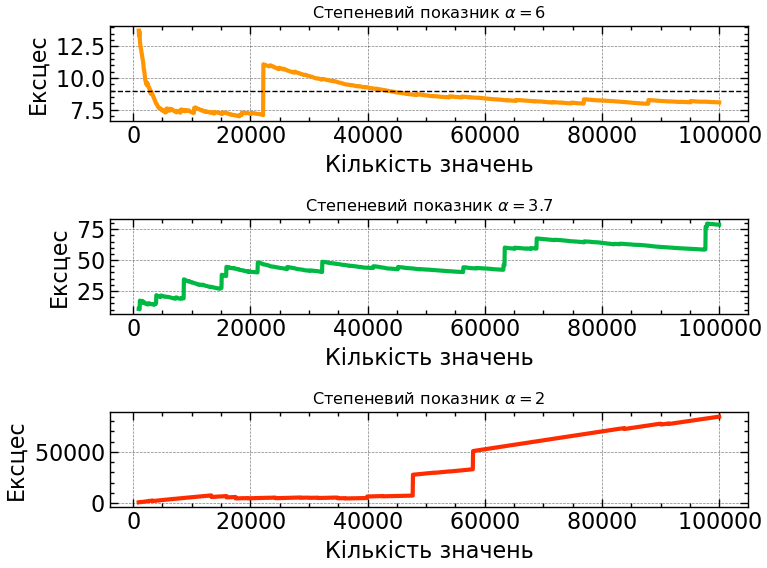

In [43]:
plt.figure()

plt.subplot(311)
plt.plot(m, kurt_alpha_60, c='C2', lw=3, zorder=2)
plt.axhline(6/(5-4) + 3, lw=1, ls='--', c='k')
plt.ylabel('Ексцес')
plt.xlabel('Кількість значень')
plt.title('Степеневий показник $\\alpha=6$')

plt.subplot(312)
plt.plot(m, kurt_alpha_37, c='C1', lw=3, zorder=2)
plt.ylabel('Ексцес')
plt.xlabel('Кількість значень')
plt.title('Степеневий показник $\\alpha=3.7$')

plt.subplot(313)
plt.plot(m, kurt_alpha_20, c='C3', lw=3, zorder=2)
plt.ylabel('Ексцес')
plt.xlabel('Кількість значень')
plt.title('Степеневий показник $\\alpha=2$')

plt.tight_layout()
plt.show();

У випадку $\alpha=6$ ($\nu=5$) ексцес скінченний і повинен приймати значення $\frac{6}{\nu - 4}+3=9$. Хоча ми бачимо деякі коливання, оціночне значення ексцесу повільно наближається до справжнього значення. Для прикладу, який відповідає степеневому показнику індексу S&P 500 з $\alpha = 3.7$, моделювання показує таку ж поведінку, що і для реальних даних: збіжність не може бути виявлена, скоріше кожна екстремальна подія збільшує ексцес; при нескінченних вибірках ми би досягли нескінченного ексцесу. У третьому випадку з $\alpha = 2$ ексцес t-розподілу Стьюдента навіть не визначений належним чином, і ми можемо побачити інший тип поведінки моделювання: зараз більшість точок даних збільшують оцінку ексцесу, а не лише кілька окремих екстремальних зразків. При такому повільно спадаючому статечному законі екстремальні значення зустрічаються повсюдно, що призводить до збільшення ексцесу при моделюванні.

::: {.callout-tip}
## Примітка

Навіть якщо певні властивості розподілу ймовірностей нескінченні, ми завжди знайдемо кінцеві вибіркові оцінки при перегляді даного набору даних просто тому, що набір даних містить лише кінцеву кількість точок. Однак, якщо теорія степеневого закону чітко говорить нам, що певна властивість нескінченна, ми не повинні ніде використовувати кінцеві оцінки і ми не повинні використовувати моделі, які вимагають, щоб ця властивість була кінцевою! Якщо ми все одно це зробимо, це в кращому випадку буде працювати лише до наступної екстремальної події, яка анулює наші минулі оцінки і --- у випадку фінансових моделей --- може збанкрутувати нас!
:::

### Як ексцес дестабілізує розрахунки волатильності

Оскільки ексцес збільшується --- або стає нескінченним --- це також впливає на нижчі моменти, найголовніше, на дисперсію. Квадратний корінь дисперсії --- це стандартне відхилення, або [волатильність](https://en.wikipedia.org/wiki/Volatility_(finance)), як це називається у фінансах. Волатильність є розповсюдженним параметром при оптимізації портфеля і практично в кожній фінансовій моделі, оскільки в кінцевому підсумку вона стала найбільш часто використовуваним показником "ризику". Щоб побачити, як ексцес впливає на оцінку волатильності, ми проводимо простий експеримент [Монте-Карло](https://en.wikipedia.org/wiki/Monte_Carlo_method): ми витягуємо щоденну прибутковість за 50 років з розподілу ймовірностей за нашим вибором (ми будемо використовувати Гаусовий і t-розподіл Стьюдента) і обчислюємо оцінку волатильності, використовуючи вибіркове стандартне відхилення. Ми робимо це не тільки один раз, але і 10000 разів, кожен раз, коли ми розраховуємо нову гіпотетичну щоденну прибутковість за 50 років і обчислюємо відповідну оцінку волатильності. Звичайно, не всі ці оцінки будуть однаковими, але коливатимуться навколо справжньої волатильності, оскільки ми маємо лише кінцеву кількість даних. Оскільки ми знаємо справжній розподіл ймовірностей, який ми використовуємо для моделювання, ми також знаємо справжню волатильність. Щоб побачити, наскільки точно ми можемо оцінити волатильність на основі даних за 50 років, ми обчислюємо відносну похибку між оцінками волатильності та справжньою волатильністю.

In [44]:
n_sim = 10000

true_var = 1.
true_vol = np.sqrt(true_var)

rand_vol = np.array([np.std(norm(0., 1.).rvs(50*252), ddof=1) for i in tqdm(range(n_sim))])

100*np.mean(np.abs(rand_vol - true_vol))/true_vol

100%|██████████| 10000/10000 [00:08<00:00, 1125.24it/s]


0.5039568642168273

In [45]:
n_sim = 10000

alpha = 6.0
nu = alpha - 1

true_var = nu/(nu-2)
true_vol = np.sqrt(true_var)

rand_vol = np.array([np.std(t(nu, 0., 1.).rvs(50*252), ddof=1) for i in tqdm(range(n_sim))])

100*np.mean(np.abs(rand_vol - true_vol))/true_vol

100%|██████████| 10000/10000 [00:13<00:00, 728.17it/s]


0.9616583563963519

In [46]:
n_sim = 10000

alpha = 4.0
nu = alpha - 1

true_var = nu/(nu-2)
true_vol = np.sqrt(true_var)

rand_vol = np.array([np.std(t(nu, 0., 1.).rvs(50*252), ddof=1) for i in tqdm(range(n_sim))])

100*np.mean(np.abs(rand_vol - true_vol))/true_vol

100%|██████████| 10000/10000 [00:14<00:00, 700.76it/s]


3.8082666425995932

In [47]:
n_sim = 10000

alpha = 3.7
nu = alpha - 1

true_var = nu/(nu-2)
true_vol = np.sqrt(true_var)

rand_vol = np.array([np.std(t(nu, 0., 1.).rvs(50*252), ddof=1) for i in tqdm(range(n_sim))])

100*np.mean(np.abs(rand_vol - true_vol))/true_vol

100%|██████████| 10000/10000 [00:14<00:00, 709.36it/s]


6.115969986022528

In [48]:
n_sim = 10000

alpha = 3.1
nu = alpha - 1

true_var = nu/(nu-2)
true_vol = np.sqrt(true_var)

rand_vol = np.array([np.std(t(nu, 0., 1.).rvs(50*252), ddof=1) for i in tqdm(range(n_sim))])

100*np.mean(np.abs(rand_vol - true_vol))/true_vol

100%|██████████| 10000/10000 [00:13<00:00, 718.23it/s]


38.47707859009605

Ми отримуємо наступні відносні похибки для різних розподілів та їх параметрів:
- Гаусовий розподіл; відн. похиб. $\approx 0.5\%$
- t-розподіл Стьюдента з $\alpha=6.0$ ($\nu=5.0$); відн. похиб. $\approx 1.0\%$
- t-розподіл Стьюдента з $\alpha=4.0$ ($\nu=3.0$); відн. похиб. $\approx 3.8\%$
- t-розподіл Стьюдента з $\alpha=3.7$ ($\nu=2.7$); відн. похиб. $\approx 6.1\%$

При степеневому показнику $\alpha= 3.7$ (що відповідає $\nu = 2.7$; як ми підрахували для S&P 500, щоб пояснити Чорний понеділок), щоденна прибутковість за 50 років все ще призводить до помилки оцінки волатильності більш ніж на $6%$! Зверніть увагу, що ця велика помилка оцінки зростатиме ще швидше, коли вона наближається до $\alpha = 3.0$, оскільки дисперсія стає нескінченною для t-розподілу Стьюдента при $\alpha = 3.0$ ($\nu = 2.0$). Виходячи з t-розподілу прибутковостей S&P 500, похибка оцінки волатильності зросла в 12 разів (!) порівняно з тим, що ми очікували б, припускаючи, що прибутковості розподілені за Гаусом.

::: {.callout-tip}
## Примітка

Чим важчі хвости розподілу прибутковостей, тим більше точок даних необхідно для досягнення необхідної достовірності оцінок певних параметрів. Пам'ятайте про це щоразу, коли ви намагаєтеся оцінити ризик інвестування у відносно новий фінансовий актив, який має дані лише за кілька років.
:::

### Наслідки для моделювання та прогнозування

Той факт, що більш високі моменти розподілу прибутковості можуть бути нескінченними і що оцінка нижчих моментів, таких як дисперсія, дестабілізується за наявності "товстих хвостів", має суттєві наслідки для деяких найбільш використовуваних моделей у фінансах. Ми коротко розглянемо дві з них, щоб проілюструвати проблему.

### Марковіц і стабільність волатильності

У 1954 році [Гаррі Марковіц](https://en.wikipedia.org/wiki/Harry_Markowitz) отримав ступінь доктора економічних наук за роботу з теорії фінансових портфелів. Його робота стала наріжним каменем [сучасної портфельної теорії](https://en.wikipedia.org/wiki/Modern_portfolio_theory) і тоді це було настільки новим, що під час захисту докторської дисертації Мілтон Фрідман стверджував, що ця робота насправді не стосується галузі економіки (як пояснив Марковіц у своїй [Нобелівській лекції](http://nobelprize.org/nobel_prizes/economics/laureates/1990/markowitz-lecture.html) у 1990 році). Марковіц стверджував, що при заданому рівні волатильності існує набір вагових коефіцієнтів розподілу активів у портфелі, які дають максимальну надлишкову прибутковість портфеля (порівняно з безризиковим активом). Якщо ви переглянете діапазон значень волатильності та обчислите максимальну віддачу портфеля, отримавши оптимальні ваги розподілу, Ви отримаєте набір *ефективних* портфелів, який також називають [межею ефективності](https://en.wikipedia.org/wiki/Efficient_frontier). Одна точка на цій межі в багатьох випадках представляє особливий інтерес, --- це точка максимуму [коефіцієнта Шарпа](https://en.wikipedia.org/wiki/Sharpe_ratio).

Коефіцієнт Шарпа --- це часто критикуваний, але також часто використовуваний показник для оцінки ефективності портфеля або фінансових активів загалом, таких як гедж-фонди або ETF. Він визначається як:

$$
S = \frac{\mu - \mu_{\text{rf}}}{\sigma}.
$$

Тут $\mu$ позначає річну прибутковість портфеля, $\mu_{\text{rf}}$ позначає річну безризикову прибутковість, а $\sigma$ позначає річну волатильність портфеля. Припускаючи нульову безризикову ставку ($\mu_{\text{rf}} = 0$), коефіцієнт Шарпа можна інтерпретувати як [співвідношення сигнал/шум](https://en.wikipedia.org/wiki/Signal-to-noise_ratio), відомий у фізиці та інженерії: максимізуючи коефіцієнт Шарпа, ми знаходимо найкращий компромісне значення, що максимізує наші прибутковості (сигнал) та мінімізує волатильності (шум).

Якщо наш портфель складається з $n$ фінансових активів з очікуваною прибутковістю $\vec{\mu} = (\mu_{1},...,\mu_{n})$, з коваріаційною матрицею $\Sigma$, яка містить інформацію про волатильність і кореляції між активами, і з вектором ваги розподілу $\vec{w} = (w_1,...,w_n)$ (нормалізовано до одиниці: $\sum_{i=1}^n w_i = 1$), тоді коефіцієнт Шарпа у контексті сучасної теорії портфеля можна обчислити наступним чином:

$$
S(\vec{w}) = \frac{\vec{w}.\vec{\mu}}{\sqrt{\vec{w}\Sigma\vec{w}^T}}.
$$

Зверніть увагу, що з цього моменту ми завжди припускаємо, що $\mu_{\text{rf}} = 0$. 

Щоб максимізувати прибутковість відносно волатильності та отримати портфель з максимальним коефіцієнтом Шарпа, ми змінюємо ваги розподілу, поки не знайдемо набір ваг $\vec{w}^*$ з максимальним коефіцієнтом Шарпа:

$$
\vec{w}^* = \text{argmax}_{\vec{w}} ~ S(\vec{w})
$$

Основне припущення, що лежить в основі сучасної теорії портфеля, полягає в тому, що об'єднаний розподіл логарифмічних прибутковостей всіх активів у портфелі може бути повністю охарактеризований мультиваріативним розподілом Гауса. Після попередніх частин цієї лабораторної ми дуже добре розуміємо цю помилку, і сучасна теорія портфеля по праву зазнала жорсткої критики за відсутність врахування "важких хвостів", наприклад, з боку Нассіма Талеба:


::: {.callout-tip}
## Нассім Талеб у *Чорний лебідь: Про (не)ймовірне в реальному житті* (ст. 277)

Після краху фондового ринку (у 1987 році) вони нагородили двох теоретиків, Гаррі Марковіца та Вільяма Шарпа, які побудували прекрасні платонівські моделі на гаусовій основі, сприяючи тому, що називається сучасною теорією портфеля. Простіше кажучи, якщо ви видалите їх гаусові припущення і розглядаєте ціни як масштабо-інваріантні, у вас залишиться гаряче повітря. Нобелівський комітет міг би протестувати моделі Шарпа і Марковіца --- вони працюють як шарлатанські ліки, що продаються в Інтернеті, --- але ніхто в Стокгольмі, схоже, про це не подумав.
:::

Тут ми просто хочемо проілюструвати наслідки припущення гаусовости, змоделювавши прибутковість двох гіпотетичних акцій і спробувавши знайти ваги розподілу по максимуму Шарпа. Як ми побачимо, великі хвости в модельованих розподілах прибутковостей вносять істотну невизначеність в розрахункові ваги розподілу --- прямий наслідок нестабільності дисперсії.

Спочатку ми генеруємо випадкові числа з Гаусового розподілу, достатнього для моделювання щоденної прибутковості двох гіпотетичних акцій за 10 років. Ми присвоюємо їм різну позитивну очікувану прибутковість і волатильність. Для простоти ми припускаємо, що кореляція між двома активами є нульовою:

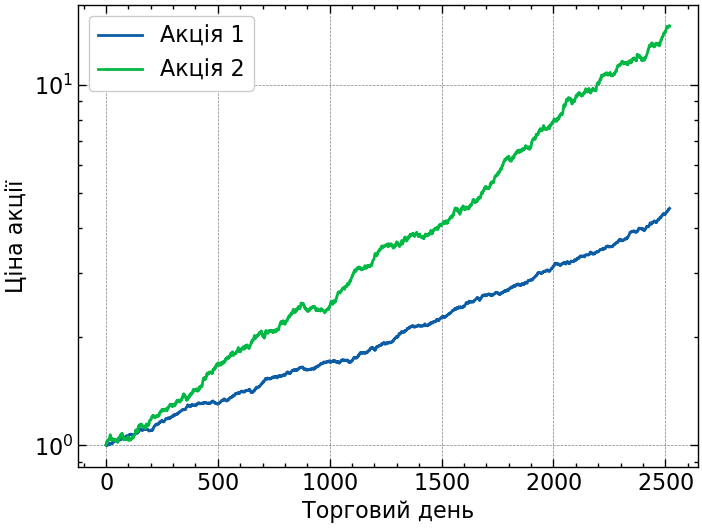

In [49]:
np.random.seed(1234)
n_years = 10

log_ret_1 = 0.0025*norm.rvs(size=n_years*252) + 0.0005
log_ret_2 = 0.0050*norm.rvs(size=n_years*252) + 0.0010

plt.figure()
plt.plot(np.exp(np.cumsum(log_ret_1)), label='Акція 1')
plt.plot(np.exp(np.cumsum(log_ret_2)), label='Акція 2')

plt.ylabel('Ціна акції')
plt.xlabel('Торговий день')
plt.legend()
plt.yscale('log')
plt.show();

Звичайно, насправді ми не знаємо *справжньої* очікуваної прибутковості або значень волатильності кореляцій між активами. Таким чином, ми повинні оцінити очікувану прибутковість за середнім значенням вибірки та матрицю коваріації за матрицею коваріації вибірки. Зверніть увагу, що існують більш складні способи оцінки цих параметрів на основі історичних даних, таких як [оцінки усадки](http://www.ledoit.net/honey.pdf) для коваріаційної матриці або [моделі розподілу Блека-Літтермана](https://sci-hub.mksa.top/10.3905/jfi.1991.408013). Ці методи, безумовно, покращують вибіркові оцінки, але загальний недолік сучасної теорії портфеля через наявність "важких хвостів" залишається. Щоб вивчити та протестувати різні методи оптимізації портфеля, рекомендуємо розглянути бібліотеку [PyPortfolioOpt](https://pyportfolioopt.readthedocs.io/en/latest/index.html), що представляє собою добре задокументований пакет Python, який реалізує як основні, так і складні методи оптимізації портфеля та дозволяє легко тестувати ці методи на реальних даних. Поки ми дотримуємося вибіркових оцінок (і використовуємо коефіцієнт 252 --- середню кількість торгових днів на рік для отримання очікуваної прибутковості в річному обчисленні і коваріації за щоденними оцінками):

In [50]:
exp_returns = np.array([np.mean(log_ret_1), np.mean(log_ret_2)])*252
cov_matrix = np.cov([log_ret_1, log_ret_2])*252

Далі ми визначаємо функцію, яка приймає ваги розподілу кандидатів, розрахункову очікувану прибутковість і коваріаційну матрицю і виводить коефіцієнт Шарпа портфеля:

In [51]:
def sharpe(weights, exp_returns, cov_matrix):
    return weights.dot(exp_returns) / np.sqrt(weights.dot(cov_matrix).dot(weights.T))

sharpe(np.array([0.5, 0.5]), exp_returns, cov_matrix)

4.810679451759804

Замість того, щоб використовувати реальний оптимізатор для пошуку ваг розподілу, які максимізують коефіцієнт Шарпа, ми просто переглядаємо всі можливі комбінації ваг з інтервалом $1\%$. Звичайно, це розумний підхід лише для двох активів, і він швидко стає нерозв'язним, використовуючи більше двох активів.

In [52]:
candidate_weights = np.array([np.linspace(0, 1, 101), 1. - np.linspace(0, 1, 101)]).T
candidate_weights[:5]

array([[0.  , 1.  ],
       [0.01, 0.99],
       [0.02, 0.98],
       [0.03, 0.97],
       [0.04, 0.96]])

Тепер ми можемо перебрати всі наші ваги-кандидати, обчислити коефіцієнт Шарпа портфеля для всіх з них, а потім вибрати оптимальний набір ваг.

In [53]:
candidate_sharpe = [sharpe(weights, exp_returns, cov_matrix) for weights in candidate_weights]
opt_weights = candidate_weights[np.argmax(candidate_sharpe)]
opt_weights

array([0.7, 0.3])

Щоб отримати уявлення про те, наскільки точно ми можемо оцінити ваги розподілу на основі гіпотетичної щоденної прибутковості за 10 років, ми зараз повторюємо цей експеримент, повторно генеруємо нові випадкові прибутковості, повторно оцінюємо очікувані прибутковості та матрицю коваріації та знаходимо оптимальні ваги. Ми робимо це 10000 разів. Зверніть увагу, що ми реєструємо лише першу вагу розподілу $w_1$ для кожного запуску без втрати інформації, оскільки друга вага безпосередньо випливає з нормалізації $w_2 = 1 - w_1$.

In [54]:
np.random.seed(1234)
opt_weight_gaussian = []

for i in tqdm(range(10000)):
    log_ret_1 = 0.0025*norm.rvs(size=n_years*252) + 0.0005
    log_ret_2 = 0.0050*norm.rvs(size=n_years*252) + 0.0010

    exp_returns = [np.mean(log_ret_1), np.mean(log_ret_2)]
    cov_matrix = np.cov([log_ret_1, log_ret_2])

    candidate_sharpe = [sharpe(weights, exp_returns, cov_matrix) for weights in candidate_weights]
    opt_weights = candidate_weights[np.argmax(candidate_sharpe)]

    opt_weight_gaussian.append(opt_weights[0])

100%|██████████| 10000/10000 [00:07<00:00, 1358.21it/s]


Нарешті, ми можемо побудувати гістограму всіх 10000 значень, які ми отримуємо для $w_1$

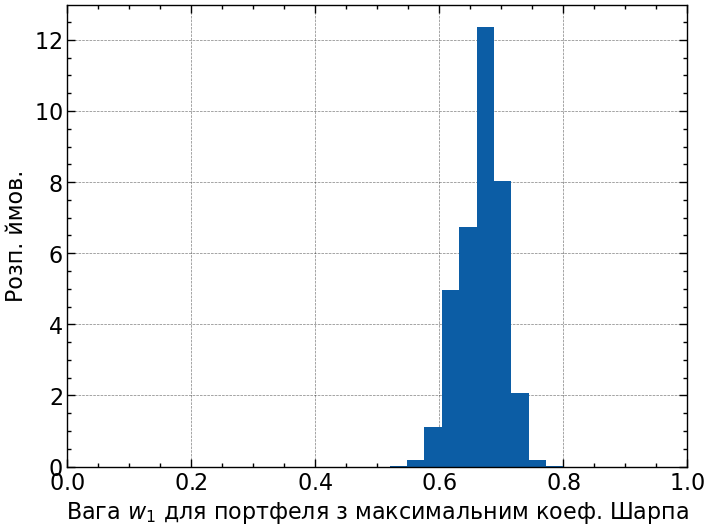

In [55]:
plt.figure()
plt.hist(opt_weight_gaussian, 10, density=True);
plt.xlim([0, 1])
plt.xlabel('Вага $w_1$ для портфеля з максимальним коеф. Шарпа')
plt.ylabel('Розп. ймов.')
plt.show();

Як ми бачимо, розподіл для першої акції коливається приблизно від $60%$ до $70%$ на основі історичних даних за 10 років. Ми можемо додатково оцінити це кількісно, обчисливши 5-й і 95-й процентилі всіх значень $w_1$. Таким чином, з упевненістю в $90%$ ми отримаємо розподіл між $61%$ і $72%$:

In [56]:
np.percentile(opt_weight_gaussian, 5), np.percentile(opt_weight_gaussian, 95)

(0.61, 0.72)

Тепер давайте повторимо цей експеримент, але цього разу ми замінимо розподіл Гауса на розподіл Стьюдента зі степеневим показником $\alpha=3.7$ (що відповідає кількості ступенів свободи $\nu=2.7$). Ми залишаємо очікувану прибутковість і волатильність (виміряні стандартним відхиленням розподілу) точно такими ж. Зверніть увагу, що стандартне відхилення стандартного t-розподілу визначається як $\sqrt{\frac{\nu}{\nu-2}}$ в нашому випадку, тому ми повинні внести поправку на цей коефіцієнт маштабування при вилученні випадкових значень зі стандартного t-розподілу. Нижче ви можете побачити пряме порівняння розподілів Гауса, використаних у наведеному вище моделюванні, та t-розподілів із відповідним середнім значенням та стандартним відхиленням.

In [57]:
scale_correction = np.sqrt(2.7/(2.7-2.))

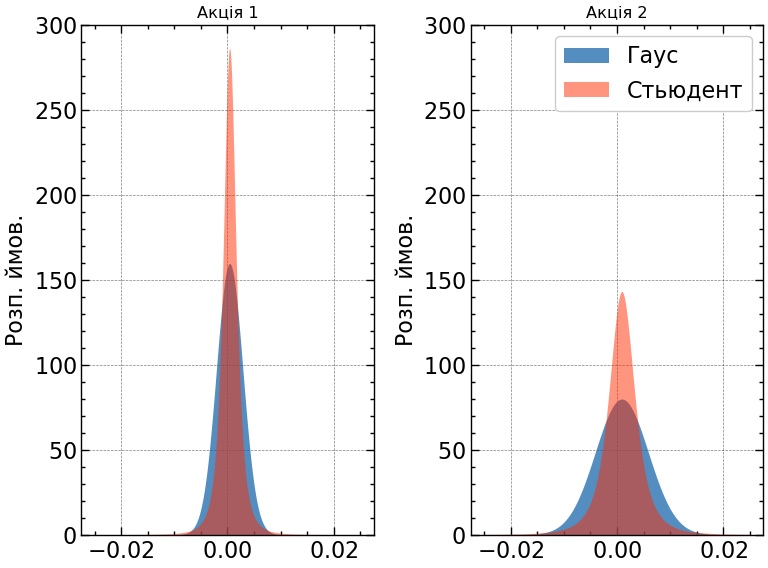

In [58]:
x = np.linspace(-0.025, 0.025, 10000)

y1_norm = norm(loc=0.0005, scale=0.0025).pdf(x)
y1_t = t(loc=0.0005, scale=0.0025/scale_correction, df=2.7).pdf(x)

y2_norm = norm(loc=0.001, scale=0.005).pdf(x)
y2_t = t(loc=0.001, scale=0.005/scale_correction, df=2.7).pdf(x)


plt.figure()

plt.subplot(121)

plt.fill_between(x, 0., y1_norm, facecolor='C0', alpha=0.7)
plt.fill_between(x, 0., y1_t, facecolor='C3', alpha=0.5)
plt.ylim([0, 300])
plt.ylabel('Розп. ймов.')
plt.title('Акція 1')

plt.subplot(122)
plt.fill_between(x, 0., y2_norm, facecolor='C0', alpha=0.7, label='Гаус')
plt.fill_between(x, 0., y2_t, facecolor='C3', alpha=0.5, label="Стьюдент")
plt.ylim([0, 300])
plt.ylabel('Розп. ймов.')
plt.title('Акція 2')
plt.legend()

plt.tight_layout()
plt.show(); 

Як ми можемо легко бачити, узгоджені t-розподіли Стьюдента насправді дають менші значення прибутковостей. Однак вони також дають набагато більш екстремальні значення, але ми не можемо легко побачити це, оскільки значення щільності ймовірності в хвостах дуже малі! Якщо ми перейдемо до логарифмічного масштабування вісі Oy, картина стане більш чіткою:

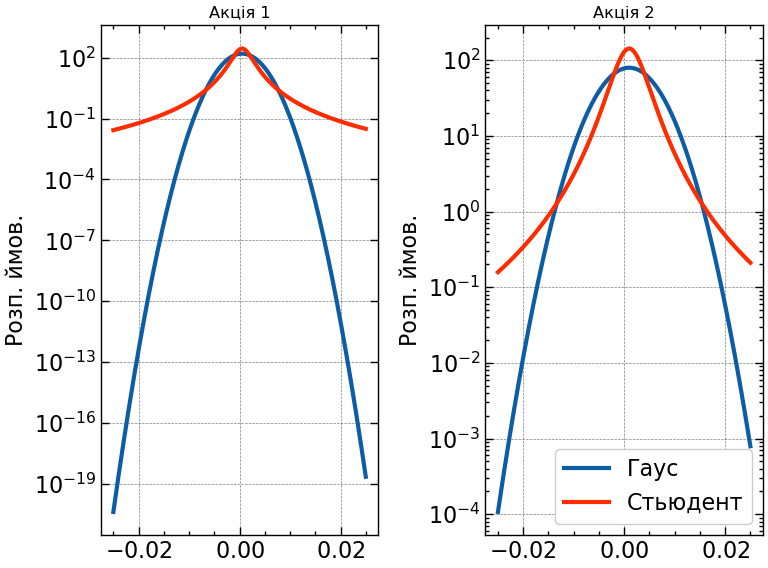

In [59]:
plt.figure()

plt.subplot(121)

plt.plot(x, y1_norm, c='C0', lw=3)
plt.plot(x, y1_t, c='C3', lw=3)
plt.ylabel('Розп. ймов.')
plt.title('Акція 1')
plt.yscale('log')

plt.subplot(122)
plt.plot(x, y2_norm, c='C0', lw=3, label='Гаус')
plt.plot(x, y2_t, c='C3', lw=3, label="Стьюдент")
plt.ylabel('Розп. ймов.')
plt.title('Акція 2')
plt.yscale('log')
plt.legend()

plt.tight_layout()
plt.show();

Тепер ми чітко бачимо, що, наприклад, ймовірність щоденних логарифмічних прибутковостей $-0.02$ для акції 1 в $10^{10}$ разів вища за умови t-розподілу порівняно з відповідним розподілом Гауса! Завжди дивіться на розподіли з логарифмічною шкалою щільності ймовірності, щоб отримати чітке уявлення про хвости. Використовуючи наші узгоджені t-розподіли, ми діємо, як і раніше, і моделюємо гіпотетичні 10-річні історичні показники для наших двох некорельованих акцій. Нижче ви можете побачити приклад. Тільки при уважному розгляді ви можете помітити, що ці криві сукупної прибутковості насправді трохи більш нерівні в порівнянні з тими, які були побудовані вище з гаусовими прибутковостями. Але різниця невловима, якщо дивитися на таку "наближену" діаграму десятирічного періоду:

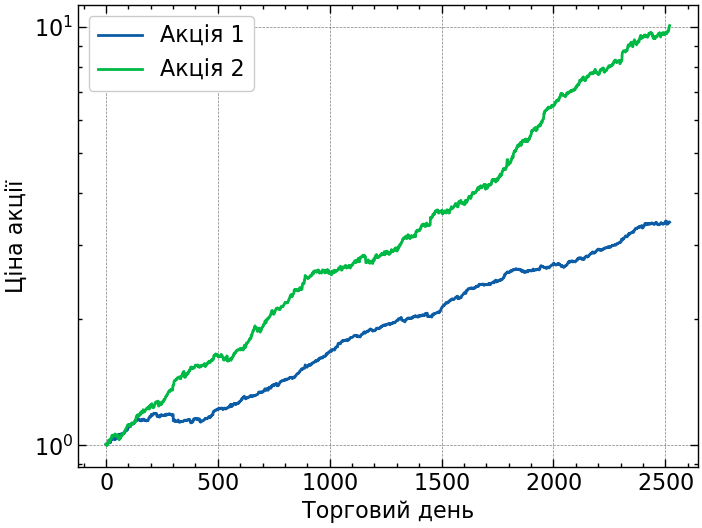

In [60]:
np.random.seed(1234)
n_years = 10

log_ret_1 = (0.0025/scale_correction)*t.rvs(df=2.7, size=n_years*252) + 0.0005
log_ret_2 = (0.0050/scale_correction)*t.rvs(df=2.7, size=n_years*252) + 0.0010

plt.figure()
plt.plot(np.exp(np.cumsum(log_ret_1)), label='Акція 1')
plt.plot(np.exp(np.cumsum(log_ret_2)), label='Акція 2')

plt.ylabel('Ціна акції')
plt.xlabel('Торговий день')
plt.legend()
plt.yscale('log')
plt.show();

Нарешті, щоб візуалізувати вплив t-розподілу на оцінку ваги розподілу, ми повторюємо наш експеримент Монте-Карло з моделювання 10000 різних 10-річних історичних значень та оцінюємо ваги розподілу в кожному з цих 10000 випадків. Потім ми будуємо графік розподілу $w_1$ і порівнюємо цей розподіл з розподілом, отриманим в результаті моделювання на основі Гауса.

In [61]:
np.random.seed(1234)
opt_weight_t = []

for i in tqdm(range(10000)):
    log_ret_1 = (0.0025/scale_correction)*t.rvs(df=2.7, size=n_years*252) + 0.0005
    log_ret_2 = (0.0050/scale_correction)*t.rvs(df=2.7, size=n_years*252) + 0.0010

    exp_returns = [np.mean(log_ret_1), np.mean(log_ret_2)]
    cov_matrix = np.cov([log_ret_1, log_ret_2])

    candidate_sharpe = [sharpe(weights, exp_returns, cov_matrix) for weights in candidate_weights]
    opt_weights = candidate_weights[np.argmax(candidate_sharpe)]

    opt_weight_t.append(opt_weights[0])

100%|██████████| 10000/10000 [00:09<00:00, 1037.43it/s]


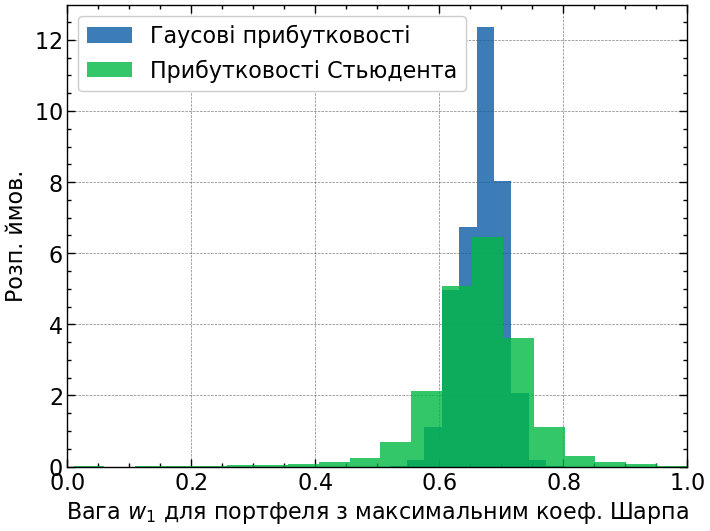

In [62]:
plt.figure()
plt.hist(opt_weight_gaussian, 10, alpha=0.8, density=True, label='Гаусові прибутковості')
plt.hist(opt_weight_t, 20, alpha=0.8, density=True, label="Прибутковості Стьюдента")
plt.xlim([0, 1])
plt.legend()
plt.xlabel('Вага $w_1$ для портфеля з максимальним коеф. Шарпа')
plt.ylabel('Розп. ймов.')
plt.show();

In [63]:
np.percentile(opt_weight_t, 5), np.percentile(opt_weight_t, 95)

(0.54, 0.77)

Як ми можемо бачити, оптимальна вага розподілу $w_1$ тепер коливається між $54\%$ і $77\%$, що приблизно в 2 рази перевищує ширину надійного інтервалу для оптимізації портфеля, яка дотримувалася припущення про гаусовість! Навіть при узгодженому стандартному відхиленні гаусового і t-розподілу, нескінченний ексцес t-розподілу дестабілізує вибіркову дисперсію наших змодельованих прибутковостей і, таким чином, знижує точність наших оціночних ваг розподілу. Хоча цей приклад, безумовно, не розкриває всіх слабкостей сучасної теорії портфеля, він допомагає нам побачити, як досить абстрактні ефекти, такі як нестабільність дисперсії через надмірний ексцес, в кінцевому результаті псують широко використовувані фінансові моделі. Використання модельованої прибутковості, заснованої на гаусовому розподілі порівняно з розподілом з великим хвостом, може допомогти виявити обмеження фінансових моделей або знайти мінімальний обсяг даних, необхідний для досягнення певної достовірності, перш ніж нова модель буде фактично запущена у виробництво!

::: {.callout-tip}
## Примітка

Важкі хвости розподілу прибутковостей можуть сильно вплинути на результати усталених математичних моделей у фінансах, або збільшуючи невизначеність параметрів (як у сучасній теорії портфеля), або приводячи до збоїв моделей поза вибірки через нескінченно великі моменти. У фінансах краще екстраполювати частоту екстремальних подій і готуватися до них за допомогою конкретних інструментів геджування, ніж намагатися передбачити майбутню прибутковість за допомогою моделей часових рядів!
:::

### Розподіл Леві

Альфа-стабільний розподіл є узагальненням розподілу Гауса, яке цінується за те, що воно тягне за собою жирні хвости. З цієї причини він широко використовується при обробці сигналів, наприклад, у медицині чи фінансах.

Загальний клас стабільних розподілів був введений і отримав цю назву французьким математиком Полем Леві на початку 1920-х років.

Раніше ця тема привертала лише помірну увагу провідних експертів, хоча були і ентузіасти, з яких можна згадати російського математика Олександра Яковича Хінчіна. Натхненням для Леві стало бажання узагальнити відому центральну граничну теорему, згідно з якою будь-який розподіл ймовірностей з кінцевою дисперсією збігається до гауссового розподілу.

Стабільні розподіли мають три виняткові властивості, які можна коротко підсумувати, заявляючи, що вони:

- інваріантні при додаванні;
- мають власну область збіжності;
- дозволяють канонічну форму характеристичної функції.

#### Інваріантність при додавані

*Випадкова величина $X$ підпорядковується стабільному розподілу $P(x) = \text{Prob}\{X \leq x\}$ якщо для будь-якого $n \geq 2$ існують додатнє значення $c_{n}$ та дійсне значення $d_{n}$ такі, що*

$$ 
X_1 + X_2 + ... + X_n \stackrel{d}{=} c_{n}X + d_{n}, 
$$

*де $X_1, X_2, ..., X_n$ характеризуються як незалежні, ідентично розподілені випадкові величини.* Також $\stackrel{d}{=}$ позначає *рівність розподілів*, тобто, випадкові величини з обох сторін мають однаковий розподіл ймовірностей.

Загалом, сума незалежних, ідентично розподілених випадкових величин результує у випадкову величину з іншим розподілом. Однак, для випадкових величин, що характеризуються *стабільним* розподілом, сума ідентично розподілених випадкових величин до величини такого самого розподілу. У цьому випадку результуюча випадкова величина (розподіл) може відрізнятися від попередніх величин характерним масштабом ($c_{n}$) та зміщенням ($d_{n}$). Якщо $d_{n} = 0$, розподіл називається *строго стабільним*.

Відомо, що нормована константа $c_{n}$ має вид 

$$
c_{n} = n^{1/\alpha} \, \text{with} \, 0 < \alpha \leq 2. 
$$

Параметр $\alpha$ має назву *характеристична експонента* або *індекс стабільності* стабільного розподілу.

Попередня теорема має альтернативну версію, що включає в суму лише дві випадкові величини. *Випадкова величина $X$ підпорядковується стабільному розподілу, якщо для будь-яких позитивних значень $A$ та $B$ існує позитивне число $C$ та дійсне число $D$ такі, що*

$$ 
A X_1 + B X_2 \stackrel{d}{=} C X + D, 
$$

*де $X_1$ та $X_2$ незалежні копії $X$*. Тоді існує значення $\alpha \in (0, 2]$ при яких значення $C$ задовільняє рівність $C^{\alpha} = A^{\alpha} + B^{\alpha}$.

Для строго стабільних розподілів $D = 0$. Це означає, що всі лінійні комбінації випадкових незалежних, ідентично розподілених випадкових величин, що підкоряються строго стабільному розподілу, результують у випадкову величину з одним і тим же типом розподілу. 

Стабільний розподіл вважається *симетричним*, якщо випадкова величина $-X$ має такий самий тип розподілу. *Симетричний* стабільний розподіл обов'язково *строго стабільний*. 

Оскільки аналітичний вираз функції щільності ймовірностей для стабільного розподілу невідома, за винятком кількох членів стабільного сімейства, більшість традиційних методів математичної статистики не можуть бути використані. Відбовідними вийнятками є

- **Гаусовий розподіл** $S_2(0,\mu, \sigma) = \mathcal{N}(\mu, 2\sigma^2)$. Гаусовий розподіл є спеціальним випадком стабільного розподілу при $\alpha = 2$ так що $\mathcal{N}(\mu, \sigma) = S(2,0,\mu, \frac{\sigma}{\sqrt{2}})$, де $\mu$ позначає середнє значення нормального розподілу, а $\sigma$ --- це стандартне відхилення. Функція щільності ймовірностей має вид 

$$ 
\frac{1}{\sigma\sqrt{2\pi}}\text{exp}^{-(x-\mu)^{2}/2\sigma^{2}}. 
$$

- **Розподіл Коші**. Розподіл Коші --- це ще одне представлення стабільного розподілу при $\alpha = 1$ та $\beta = 0$ такими, що $Cauchy(\delta, \gamma) = S_1(1,0,\gamma,\delta)$, де $\gamma$ --- це параметр масштабування, а $\delta$ --- це параметр зсуву розподілу Коші. Функція щільності ймовірностей представлена як: 

$$ 
\frac{\gamma}{\pi((x-\delta)^2 + \gamma^2)}, \, -\infty < x < \infty. 
$$

- **Розподіл Леві** також є вийнятком із класу стабільних розподілів, де $\alpha = 0.5$ і $\beta = 1$. Іншими словами, $Levy(\delta, \gamma) = S_{1/2}(0.5, 1, \gamma, \delta)$. Функція щільності ймовірностей має вид 

$$ 
\sqrt{\frac{\gamma}{2\pi}}\frac{1}{(x-\delta)^{3/2}}\exp{\left[ \frac{-\gamma}{2(x-\delta)} \right]}, \, \delta < x < \infty. 
$$

Якщо $X \sim S_{1/2}(0.5, 1, \gamma, \delta)$, тоді для $x > 0$

$$ 
P(X \leq x) = 2 \left( 1 - \phi \left( \sqrt{\frac{\gamma}{x}} \right) \right), 
$$

де $\phi$ позначає кумулятивну функцію нормального розподілу.

#### Область збіжності

Інше (еквівалентне) визначення стверджує, що стабільні розподіли --- це єдині розподіли, які можна отримати при границі нормалізованих сум незалежних, ідентично розподілених випадкових величин. Кажуть, що випадкова величина $X$ має область збіжності, тобто якщо існує послідовність незалежних, ідентично розподілених випадкових величин $Y_1, Y_2, ...$ і послідовності позитивних чисел ${\gamma_n}$ і дійсних чисел ${\delta_n}$ таких, що

$$  
\frac{Y_1 + Y_2 + ... + Y_n}{\gamma_n} + \delta_n \stackrel{d}{\Rightarrow} X.  
$$

Коли $X$ це гаусова випадкова величина, а $Y_i's$ є незалежними, ідентично розподіленими випадковими величинами з визначенною дисперсією, тоді рівняння вище є твердженням звичайної *центральної граничної теореми*. Область збіжності $X$ вважається *нормальною* коли $\gamma_n = n^{1/\alpha}$. 

#### Канонічні представлення характеристичної функції

Чотири параметри використовуються для опису випадкової величини, що слідує за стабільним розподілом: $X \sim S(\alpha, \beta, \mu, \gamma)$. Параметр $\alpha \in (0, 2]$ --- це той, який нас найбільше зацікавить. Цей параметр визначає товщину хвостів. Параметр $\beta \in [-1, 1]$ є параметром асиметрії. Останні два параметри позначають розташування $(\mu \in \Re)$ і масштаб $(\gamma > 0)$ розподілу. Альфа-стабільний розподіл немає жодного аналітичного виразу для щільності ймовірності $X$, але ми можемо охарактеризувати його характеристичною функцією:

$$
    \begin{split}
    \phi(t) &= E\left[\exp(itX)\right] \\
            &= 
        \begin{cases} 
            \exp\left(i \mu t - \gamma^{\alpha}|t|^{\alpha} \left[1-i\beta\text{sign}(t)\tan{\frac{\pi\alpha}{2}}\right]\right) & \text{if} \, \alpha \neq 1 \\ \exp\left(i \mu t - \gamma|t| \left[1+i\beta\text{sign}(t)\frac{2}{\pi}\log{|t|}\right]\right) & \text{if} \, \alpha = 1. 
        \end{cases} 
    \end{split}
$$

Ми могли б використовувати перетворення Фур'є, щоб отримати функцію щільності розподілу ймовірностей з характеристичної функції: 

$$ 
f(x) = \frac{1}{2\pi}\int_{-\infty}^{+\infty} \phi(t) \cdot \exp(-itX) dt. 
$$

Але наведена вище параметризація не є повністю задовільною, оскільки функція щільності розподілу ймовірностей не є безперервною, зокрема, при $\alpha = 1$. Дійсно, коли $\beta > 0$, щільність розподілу зміщується вправо, коли
$\alpha < 1$ і вліво, коли $\alpha > 1$, зі зсувом в сторону $+\infty$ (відповідно $-\infty$), коли $\alpha$ прагне до 1. Таким чином, для прикладного аналізу даних та інтерпретації коефіцієнтів слід уникати такої параметризації. 

Існує багато параметризацій для стабільних законів, і ці різні параметризації викликали велику плутанину. Різноманітність параметризацій обумовлена поєднанням історичної еволюції плюс численними проблемами, які були проаналізовані за допомогою спеціалізованих форм стабільного розподілу. Є вагомі причини використовувати різні параметризації в різних ситуаціях. Якщо в пріорітеті чисельні розрахунки, робота із даними, то краще використовувати одну параметризацію. Якщо бажані прості алгебраїчні властивості розподілу або аналітичні властивості строго стійких законів, то краще розглянути декілька параметризацій. Нолан запропонував використовувати параметризацію Золотарьова (M), яку також часто позначають як $S^{0}$. Характеристична функція, що відповідає $X \sim S^{0}(\alpha, \beta, \mu_{0}, \gamma)$, дорівнює:

$$
    \begin{split}
    \phi(t) &= E\left[\exp(itX)\right] \\
            &= 
        \begin{cases} 
            \exp\left(i \mu_{0} t - \gamma^{\alpha}|t|^{\alpha} \left[1+i\beta\text{sign}(t)\tan{\frac{\pi\alpha}{2}}\left( \gamma^{1-\alpha}|t|^{1-\alpha}-1 \right)\right]\right) & \text{if} \, \alpha \neq 1 \\ \exp\left(i \mu_{0} t - \gamma|t| \left[1+i\beta\text{sign}(t)\frac{2}{\pi}\left(\log{|t|} + \log{\gamma}\right) \right]\right) & \text{if} \, \alpha = 1. 
        \end{cases}
    \end{split} 
$$

Ця альтернативна параметризація недалека від зазначеної напочатку. Єдина відмінність стосується параметра $\mu$, який у даній параметризації коригує зсув для значень $\alpha$ близьких до 1:

$$ 
\mu_{0} = \begin{cases} \mu + \beta\gamma\tan{\frac{\pi\alpha}{2}} & \text{if} \, \alpha \neq 1 \\ \mu + \beta\frac{2}{\pi}\gamma\log{\gamma} & \text{if} \, \alpha = 1. \end{cases} 
$$

#### Метод розрахунку параметрів $\alpha$-стабільного розподілу

Числені методи, такі як метод Маккаллоха, заснований на квантилях, і метод оцінки максимальної правдоподібності були розроблені в результаті відсутності аналітичних рішень. Припустимо, що $\text{X} = (X_1, ... , X_T)$ вектор, що складається з $T$ незалежних ідентично розподілених випадкових величин із розподілу Парето, і також $x \sim S_{\alpha}(\alpha, \beta, \delta, \gamma)$. Визначивши $\theta = (\alpha, \beta, \delta, \gamma)$, Митник, Доганоглу та Ченайо розробили алогритм максимальної правдоподібності і показали, що $\theta$ можна розрахувати, максимізуючи функцію логарифмічної правдоподібності

$$ 
l(\theta, x) = \sum_{i=1}^{T}\log{f(x_{i}, \theta)}.
$$

Дюмушель застосував метод максимальної правдоподібності до стабільного розподілу і визначив функцію правдоподібності наступним чином: 

$$ 
L(\theta) = \prod_{k=1}^{n}S_{\alpha,\beta} \left( \frac{X_{k} - \delta}{\gamma} \right) \Big/ \gamma, 
$$ 

де $\theta = (\alpha, \beta, \delta, \gamma)$ опираючись на $x = (x_1, ... , x_n)$ для розміру вибірки $n$. 

## Хід роботи

### Зчитування з Yahoo Finance

In [7]:
# встановлення назви індексу
symbol = "^BSESN" 

# встановлення діапазону з яким будемо працювати
start = "1980-01-01"
end = "2022-11-07"

# завантаження даних з Yahoo
data = yf.download(symbol, start, end)
time_ser = data['Adj Close'].copy()

# підпис по вісі Ох 
xlabel = 'time, days'

# підпис по вісі Оу
ylabel = symbol                       

# збереження результату в текстовий документ 
np.savetxt(f'{symbol}_initial_time_series.txt', time_ser_1.values)

[*********************100%%**********************]  1 of 1 completed


### Виведення графіку досліджуваного ряду

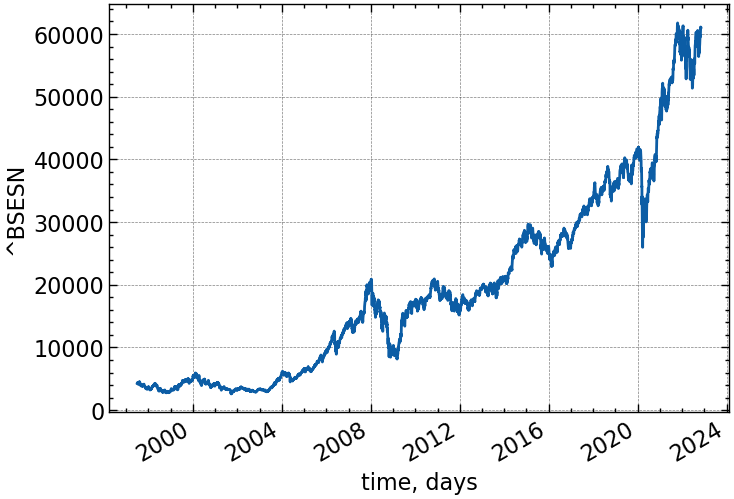

In [17]:
time_ser.plot(figsize=(8,6), xlabel=xlabel, ylabel=fr"{symbol}")
plt.savefig('ts1.jpg', bbox_inches="tight")
plt.show();

### Побудова розподілу Леві та розрахунок параметрів для всього ряду

In [10]:
ret_type = 4
for_levy = time_ser.copy()

if ret_type == 1:
    pass
elif ret_type == 2:
    for_levy = for_levy.diff()
elif ret_type == 3:
    for_levy = for_levy.pct_change()
elif ret_type == 4:
    for_levy = for_levy.pct_change()
    for_levy -= for_levy.mean()
    for_levy /= for_levy.std()
elif ret_type == 5: 
    for_levy = for_levy.pct_change()
    for_levy -= for_levy.mean()
    for_levy /= for_levy.std()
    for_levy = for_levy.abs()
elif ret_type == 6:
    for_levy -= for_levy.mean()
    for_levy /= for_levy.std()

for_levy = for_levy.dropna().values

### Підганяємо розподіл Леві та Гаусовий для порівняння

In [11]:
params = levy.fit_levy(for_levy)
mean, std = norm.fit(for_levy)

### Отримуємо параметри розподілу Леві у відповідності до однієї із параметризацій, що пропонує пакет $levy$

In [12]:
alpha, beta, mu, sigma = params[0].get('1')

### Будуємо теоретичні та емпіричні розподіли 

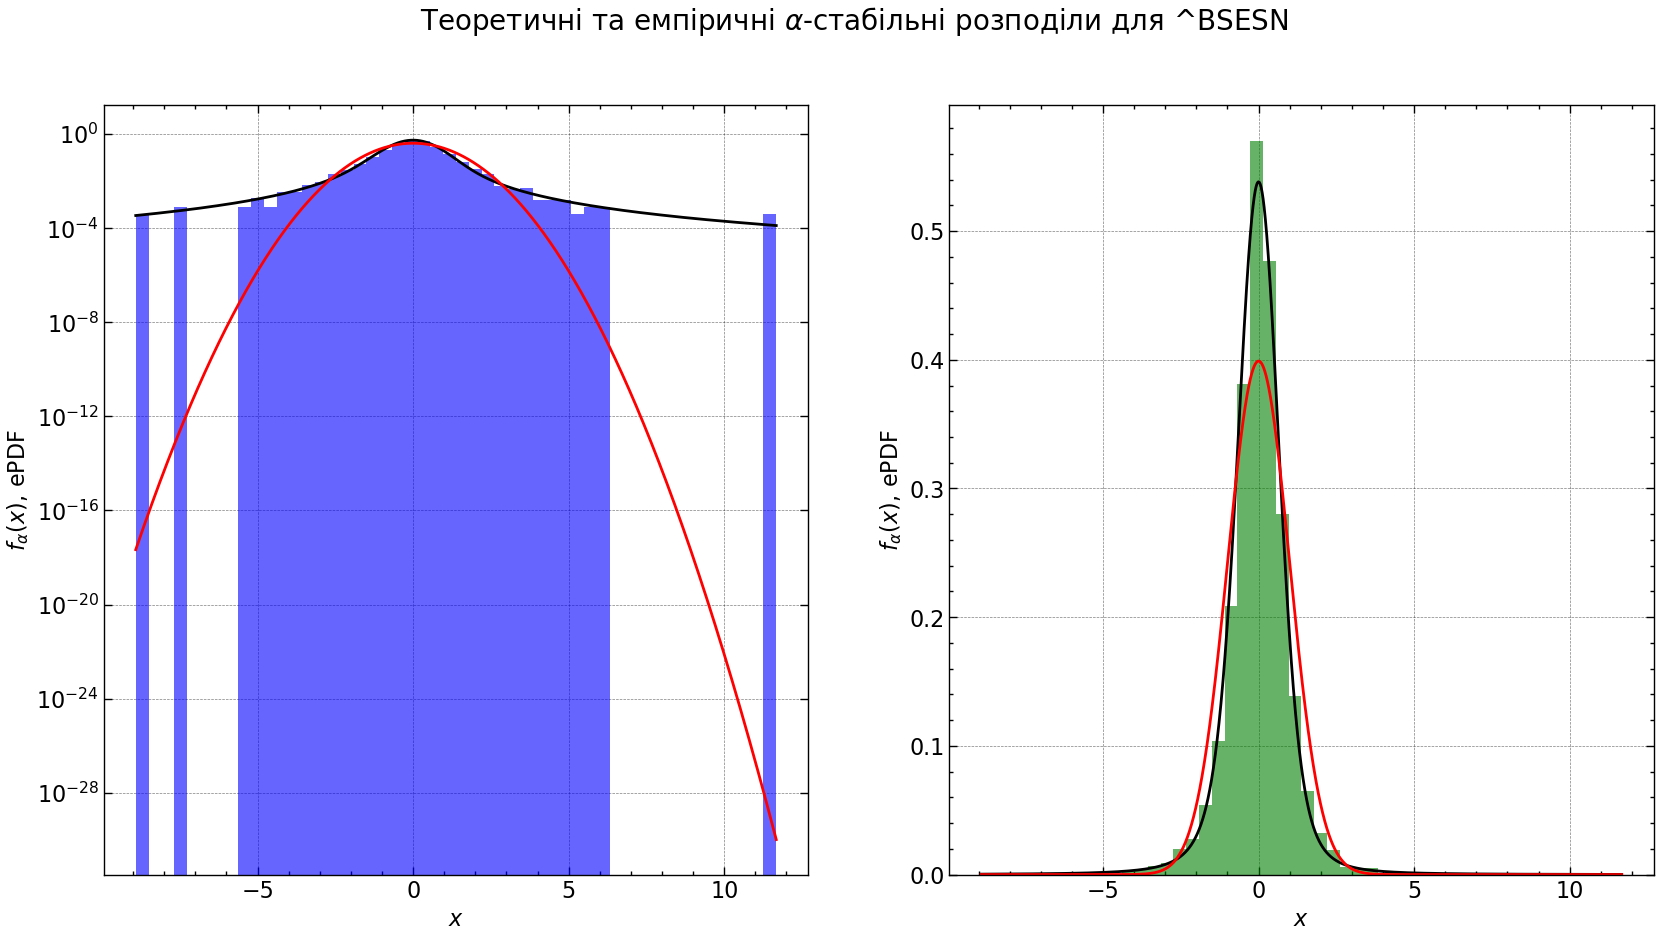

In [16]:
#| label: fig-pdfs-ther-emp 
#| fig-cap: "Теоретичні та емпіричні альфа-стабільні функції щільності ймовірностей"

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].hist(for_levy, bins=50, density=True, alpha=0.6, color='b')

xmin = for_levy.min()
xmax = for_levy.max()

x = np.linspace(xmin, xmax, len(for_levy))
pdf = levy.levy(x, alpha, beta, mu, sigma)
pdf_norm = norm.pdf(x, mean, std)

fig.suptitle(fr'Теоретичні та емпіричні $\alpha$-стабільні розподіли для {symbol}', fontsize=20)

ax[0].plot(x, pdf, 'k', linewidth=2)
ax[0].plot(x, pdf_norm, 'r', linewidth=2)
ax[0].set_yscale('log')
ax[0].set_xlabel(r'$ x $')
ax[0].set_ylabel(r'$ f_{\alpha}(x), \, \mathrm{ePDF}$')

ax[1].hist(for_levy, bins=50, density=True, alpha=0.6, color='g')
ax[1].plot(x, pdf, 'k', linewidth=2)
ax[1].plot(x, pdf_norm, 'r', linewidth=2)
ax[1].set_xlabel(r'$ x $')
ax[1].set_ylabel(r'$ f_{\alpha}(x), \, \mathrm{ePDF}$')


plt.show();

### Виводимо параметри розподілу Леві для заданого індексу

In [18]:
print(fr"Параматери alpha = {alpha:.2f}, beta = {beta:.2f}, mu = {mu:.2f}, sigma = {sigma:.2f}")

Параматери alpha = 1.63, beta = -0.11, mu = -0.01, sigma = 0.53


Для досліджуваного індексу бачимо, що параметр $\alpha < 2.0$ та $\beta < 0$, що вказує на відхилення розподілу даного індексу від нормального. Тобто, для даного ряду переважаючими є кризові явища, на що вказують важкі хвости розподілу. Із порівняльного аналізу Гауссового та Леві розподілів бачимо, що хвости нормального розподілу значно недооцінюють ймовірність появи кризових явищ чого, наприклад, не скажешь про альфа-стабільний розподіл. Взявши логарифм значень ймовірності по осі $Oy$ ми можемо спостерігати, що, наприклад, недооцінка негативних прибутковостей Гауссовим розподілом, у порівнянні з альфа-стабільним, складає $\approx 10^{15}$ порядків. Для позитивних прибутковостей, що перевищують значення $+10\sigma$ недооцінка Гауссовим розподілом складає $\approx 10^{27}$ порядків. Теоретичне значення альфа-стабільного розподілу достатньо точно враховує важкі хвости емпіричного розподілу, що також виражається високим ексцесом розподілу. Також варто зазначити, що коефіцієнт асиметрії $\beta$ вказує на невеличке зміщення розподілу в ліву сторону, що також демонструє переважання кризових явищ. 

### Дослідження поведінки альфа-стабільного розподілу Леві

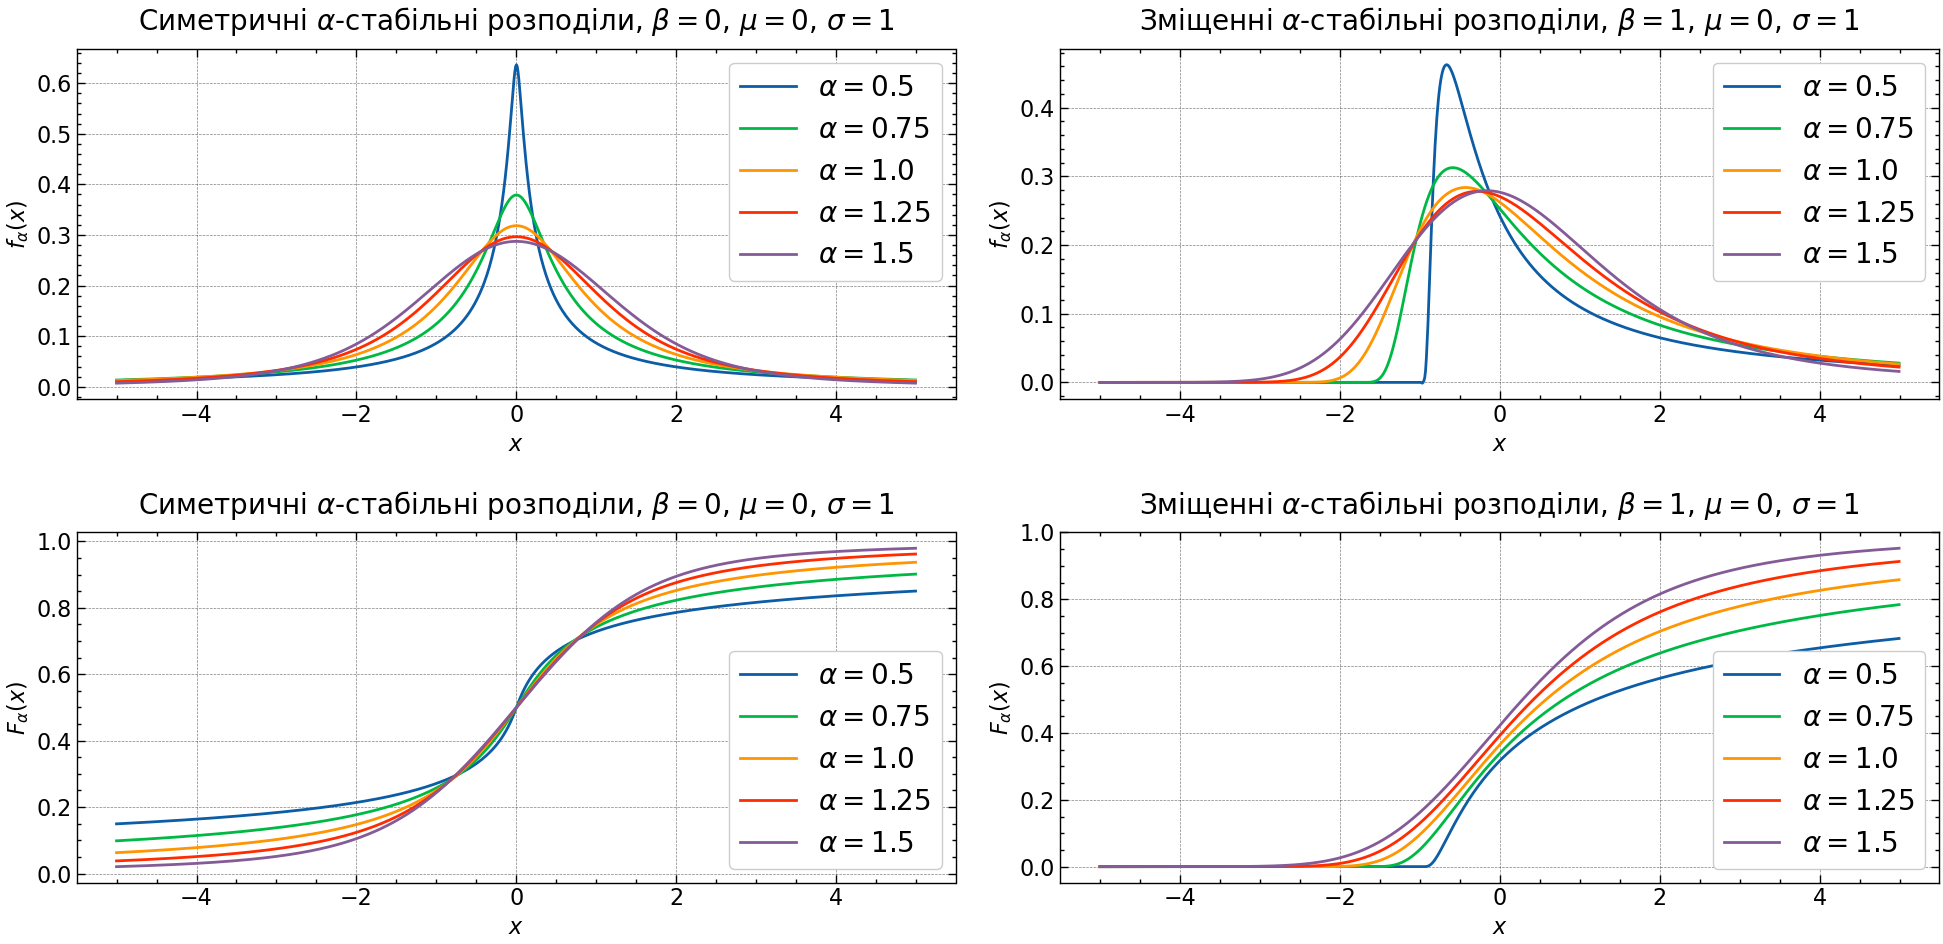

In [21]:
#| label: fig-pdfs-dependence 
#| fig-cap: "Залежність функції щільності ймовірностей альфа-стабільного розподілу Леві
#| та кумулятивної функції щільності від різних значень параметрів розподілу"

x = np.arange(-5, 5, .01)
beta_1 = 0
mu = 0 
sigm = 1 

beta_2 = 1.0

fig, ax = plt.subplots(2, 2, figsize=(20, 10))

ax[0][0].plot(x, levy.levy(x, 0.5, beta_1, mu, sigm), label = r"$ \alpha=0.5 $")
ax[0][0].plot(x, levy.levy(x, 0.75, beta_1, mu, sigm), label = r"$ \alpha=0.75 $")
ax[0][0].plot(x, levy.levy(x, 1.0, beta_1, mu, sigm), label = r"$ \alpha=1.0 $")
ax[0][0].plot(x, levy.levy(x, 1.25, beta_1, mu, sigm), label = r"$ \alpha=1.25 $")
ax[0][0].plot(x, levy.levy(x, 1.5, beta_1, mu, sigm), label = r"$ \alpha=1.5 $")

ax[0][0].set_title(r"Симетричні $\alpha$-стабільні розподіли, $ \beta = 0 $, $ \mu = 0 $, $ \sigma = 1 $", y=1.03, fontsize=20)

ax[0][0].legend(fontsize=20)

ax[0][0].set_xlabel(r"$ x $")
ax[0][0].set_ylabel(r"$ f_{\alpha}(x) $")


ax[0][1].plot(x, levy.levy(x, 0.5, beta_2, mu, sigm), label = r"$ \alpha=0.5 $")
ax[0][1].plot(x, levy.levy(x, 0.75, beta_2, mu, sigm), label = r"$ \alpha=0.75 $")
ax[0][1].plot(x, levy.levy(x, 1.0, beta_2, mu, sigm), label = r"$ \alpha=1.0 $")
ax[0][1].plot(x, levy.levy(x, 1.25, beta_2, mu, sigm), label = r"$ \alpha=1.25 $")
ax[0][1].plot(x, levy.levy(x, 1.5, beta_2, mu, sigm), label = r"$ \alpha=1.5 $")

ax[0][1].set_title(r"Зміщенні $\alpha$-стабільні розподіли, $ \beta = 1 $, $ \mu = 0 $, $ \sigma = 1 $", y=1.03, fontsize=20)

ax[0][1].legend(fontsize=20)

ax[0][1].set_xlabel(r"$ x $")
ax[0][1].set_ylabel(r"$ f_{\alpha}(x) $")


ax[1][0].plot(x, levy.levy(x, 0.5, beta_1, mu, sigm, cdf=True), label = r"$ \alpha=0.5 $")
ax[1][0].plot(x, levy.levy(x, 0.75, beta_1, mu, sigm, cdf=True), label = r"$ \alpha=0.75 $")
ax[1][0].plot(x, levy.levy(x, 1.0, beta_1, mu, sigm, cdf=True), label = r"$ \alpha=1.0 $")
ax[1][0].plot(x, levy.levy(x, 1.25, beta_1, mu, sigm, cdf=True), label = r"$ \alpha=1.25 $")
ax[1][0].plot(x, levy.levy(x, 1.5, beta_1, mu, sigm, cdf=True), label = r"$ \alpha=1.5 $")

ax[1][0].set_title(r"Симетричні $\alpha$-стабільні розподіли, $ \beta = 0 $, $ \mu = 0 $, $ \sigma = 1 $", y=1.03, fontsize=20)

ax[1][0].legend(fontsize=20, loc="lower right")

ax[1][0].set_xlabel(r"$ x $")
ax[1][0].set_ylabel(r"$ F_{\alpha}(x) $")

ax[1][1].plot(x, levy.levy(x, 0.5, beta_2, mu, sigm, cdf=True), label = r"$ \alpha=0.5 $")
ax[1][1].plot(x, levy.levy(x, 0.75, beta_2, mu, sigm, cdf=True), label = r"$ \alpha=0.75 $")
ax[1][1].plot(x, levy.levy(x, 1.0, beta_2, mu, sigm, cdf=True), label = r"$ \alpha=1.0 $")
ax[1][1].plot(x, levy.levy(x, 1.25, beta_2, mu, sigm, cdf=True), label = r"$ \alpha=1.25 $")
ax[1][1].plot(x, levy.levy(x, 1.5, beta_2, mu, sigm, cdf=True), label = r"$ \alpha=1.5 $")

ax[1][1].set_title(r"Зміщенні $\alpha$-стабільні розподіли, $\beta = 1$, $\mu = 0$, $\sigma = 1$", y=1.03, fontsize=20)

ax[1][1].legend(fontsize=20, loc="lower right")

ax[1][1].set_xlabel(r"$ x $")
ax[1][1].set_ylabel(r"$ F_{\alpha}(x) $")

fig.tight_layout()
plt.show();

### Задання ширини вікна та кроку

У даному блоці оберемо тип ряду для якого і виконуватимуться розрахунки. Перед нами представлено 6 варіантів представлення часового ряду. Виконуватимемо подальші обчислення для стандартизованих прибутковостей, оскільки згідно багатьом роботам було показано, що розподіл прибутковостей тих же самих фінансових активів (фондових індексів, валютних, криптовалют, тощо) виходить за межі нормального Гауссового розподілу. Покажемо це у даному ноутбуці та застосуємо альфа-стабільний розподіл Леві для кращого моделювання складних систем та передчасної ідентифікації кризових явищ. 

In [9]:
window = 250 # ширина сковзного вікна
tstep = 1 # крок

ret_type = 4 # тип ряду: 1 - вихідний, 2 - детрендований (різниця між теперішнім значенням та попереднім)
                        # 3 - стандартизовані прибутковості, 4 - стандартизований ряд, 5 - абсолютні значення (волатильність)
                        # 6 - стандартизований вихідний ряд
        
length = len(time_ser)

### Розраховуємо параметри Леві, використовуючи алгоритм сковзного вікна

In [22]:
alpha = []
beta = []
mu = []
sigma = []

In [23]:
for i in tqdm(range(0,length-window,tstep)):
    fragm = time_ser.iloc[i:i+window].copy() # відбираємо фрагмент та в подальшому відбираємо потрібний тип ряду
    if ret_type == 1:
        pass
    elif ret_type == 2:
        fragm = fragm.diff()
    elif ret_type == 3:
        fragm = fragm.pct_change()
    elif ret_type == 4:
        fragm = fragm.pct_change()
        fragm -= fragm.mean()
        fragm /= fragm.std()
    elif ret_type == 5: 
        fragm = fragm.pct_change()
        fragm -= fragm.mean()
        fragm /= fragm.std()
        fragm = fragm.abs()
    elif ret_type == 6:
        fragm -= fragm.mean()
        fragm /= fragm.std()
        
    fragm = fragm.dropna().values 
    
    params = levy.fit_levy(fragm)
    
    a, b, m, s = params[0].get('0')
    
    alpha.append(a)
    beta.append(b)
    mu.append(m)
    sigma.append(s)


100%|██████████| 5995/5995 [24:13<00:00,  4.12it/s]


### Зберігаємо значення у текстовому документі

In [25]:
np.savetxt(f"alpha_idx_{symbol}_{window}_{tstep}_{ret_type}.txt", alpha)
np.savetxt(f"beta_idx_{symbol}_{window}_{tstep}_{ret_type}.txt", beta)
np.savetxt(f"mu_idx_{symbol}_{window}_{tstep}_{ret_type}.txt", mu)
np.savetxt(f"sigma_idx_{symbol}_{window}_{tstep}_{ret_type}.txt", sigma)

### Визначимо функцію для побудови парних графіків

In [26]:
def plot_pair(x_values, 
              y1_values,
              y2_values,  
              y1_label, 
              y2_label,
              x_label, 
              file_name, clr="magenta"):

    fig, ax = plt.subplots()

    ax2 = ax.twinx()

    ax2.spines.right.set_position(("axes", 1.03))

    p1, = ax.plot(x_values, 
                  y1_values, 
                  "b-", label=fr"{y1_label}")
    p2, = ax2.plot(x_values,
                   y2_values, 
                   color=clr, 
                   label=y2_label)

    ax.set_xlabel(x_label)
    ax.set_ylabel(f"{y1_label}")

    ax.yaxis.label.set_color(p1.get_color())
    ax2.yaxis.label.set_color(p2.get_color())

    tkw = dict(size=2, width=1.5)

    ax.tick_params(axis='x', **tkw)
    ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
    ax2.tick_params(axis='y', colors=p2.get_color(), **tkw)


    ax2.legend(handles=[p1, p2])

    plt.savefig(file_name + ".jpg")
        
    plt.show();

### Виводимо динаміку показника стабільності $\alpha$

In [27]:
measure_label = r'$\alpha$'
file_name = f"alpha_idx_{symbol}_{window}_{tstep}_{ret_type}"

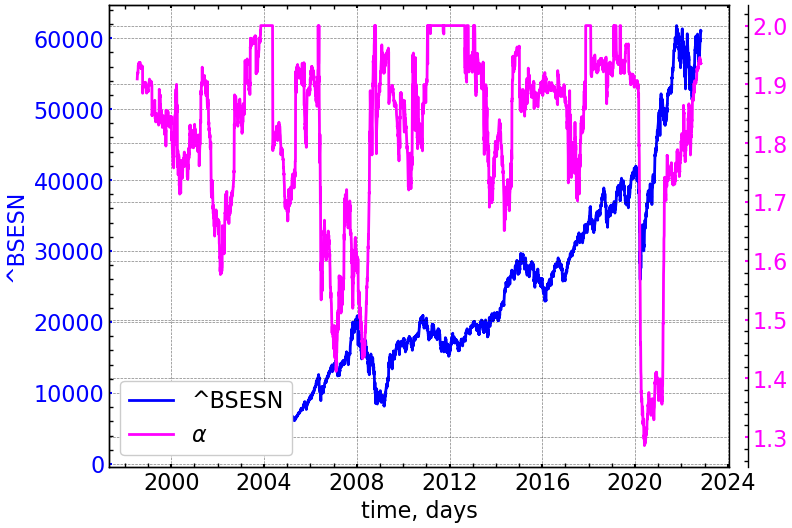

In [28]:
#| label: fig-alpha  
#| fig-cap: "Динаміка фондового індексу BSESN та показника стабільності"

plot_pair(time_ser.index[window:length:tstep],
          time_ser.values[window:length:tstep],
          alpha, 
          ylabel, 
          measure_label,
          xlabel,
          file_name)

Параметр $\alpha$ (індекс стабільності хвостів розподілу) починає спадати у (перед)кризовий період, що робить його індикатором(-передвісником) кризових явищ. Під час криз у розподілі прибутковостей зростає ексцес, а самі хвости стають важчими, на що даний показник реагує передчасно.

Наступним розглянемо параметр асиметрії $\beta$:

### Виводимо динаміку індексу асиметрії $\beta$

In [29]:
measure_label = r'$\beta$'
file_name = f"beta_idx_{symbol}_{window}_{tstep}_{ret_type}"

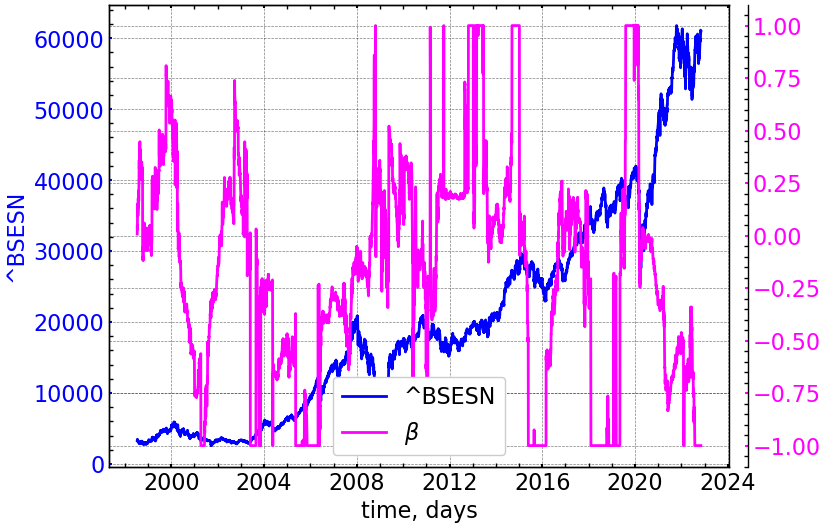

In [30]:
#| label: fig-beta  
#| fig-cap: "Динаміка фондового індексу BSESN та показника асиметрії"

plot_pair(time_ser.index[window:length:tstep],
          time_ser.values[window:length:tstep],
          beta, 
          ylabel, 
          measure_label,
          xlabel,
          file_name)

Динаміка даної міри виглядає набагато хаотичніше у порівнянні з індексом стабільності. Для представлених результатів можна зробити наступний висновок: у передкризовий період даний показник має зростати, вказуючи на значну правосторонню асиметрію розподілу прибутковостей (переважання позитивних прибутковостей). Для кризового періоду цей показник має спадати, вказуючи на домінацію негативних прибутковостей (лівостороння асиметрія розподілу). Даний показник важко розглядати у якості надійного індикатора, оскільки його коливання представляються значними навіть при незначних падіннях представленого фондового індексу. 

Наступним розглянемо індекс розташування (зміщення) альфа-стабільного розподілу:

### Виводимо динаміку параметру зміщення $\mu$

In [31]:
measure_label = r'$\mu$'
file_name = f"mu_idx_{symbol}_{window}_{tstep}_{ret_type}"

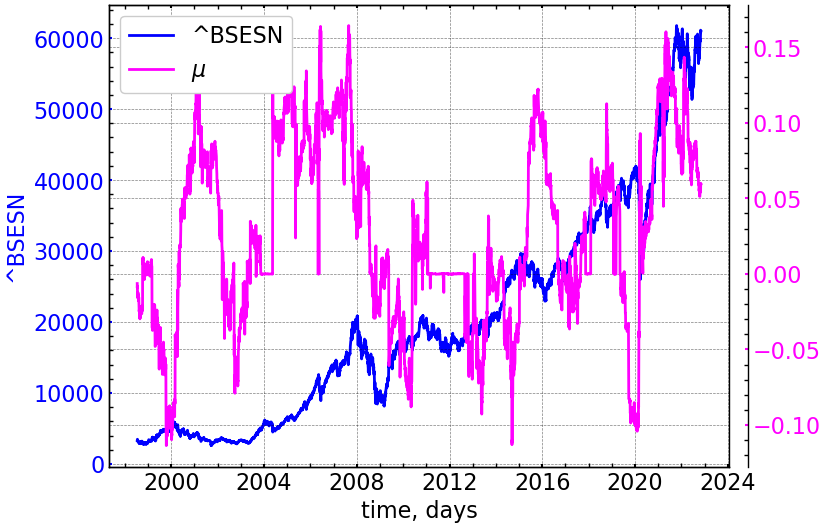

In [32]:
#| label: fig-mu  
#| fig-cap: "Динаміка фондового індексу BSESN та показника зміщення"

plot_pair(time_ser.index[window:length:tstep],
          time_ser.values[window:length:tstep],
          mu, 
          ylabel, 
          measure_label,
          xlabel,
          file_name)

Показник розташування $\mu$ потроху спадає у кризовий період, демонструючи зміщення розподілу в сторону негативних прибутковостей. Тим не менш, цей розподіл представляєть настільки ж хаотичним як і показник асиметрії $\beta$. 

Останні рисунки демонструють динаміку показника масштабування розподілу $\sigma$:

### Виводимо динаміку параметра масштабу $\sigma$

In [34]:
measure_label = r'$\sigma$'
file_name = f"sigma_idx_{symbol}_{window}_{tstep}_{ret_type}"

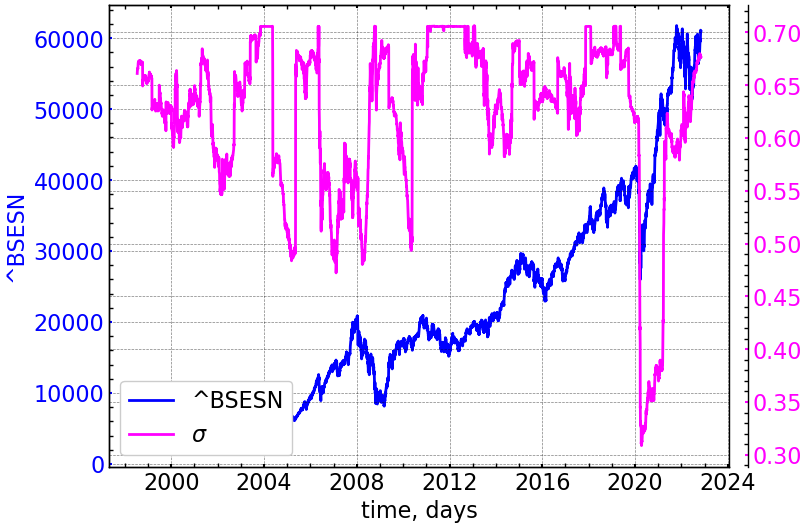

In [35]:
#| label: fig-sigma  
#| fig-cap: "Динаміка фондового індексу BSESN та показника масштабу"

plot_pair(time_ser.index[window:length:tstep],
          time_ser.values[window:length:tstep],
          sigma, 
          ylabel, 
          measure_label,
          xlabel,
          file_name)

Із представлених результатів видно, що даний показник спадає у (перед)кризовий період, вказуючи на зменшення масштабу (форми) альфа-стабільного розподілу Леві.

Отже, з усіх 4-ох показників, показник стабільності $\alpha$ є найкращим для ідентифікації кризових явищ та побудови надійних стратегій ризик-менеджменту. 

## Висновок

Стабільні розподіли --- захоплюючий і плідний об'єкт досліджень в теорії ймовірностей; більше того, в даний час вони мають велику цінність при моделюванні складних процесів у фізиці, астрономії, економіці, теорії комунікацій, тощо. 

У даній роботі було представлено теоретичні та чисельні обгрунтування в сторону альфа-стабільного розподілу Леві в якості практичної моделі для кращого розуміння та передбачення кризових явищ у складних системах.  

Тут ми представили розрахунки як для усього ряду, так і для його підфрагментів, використовуючи алгоритм ковзного вікна. Виходячи з усього ряду прибутковостей, видно, що хвости їх розподілу далеко виходять за межі Гаусового. Найкраще емпіричний розподіл прибутковостей збігається саме з теоретичним альфа-стабільним розподілом Леві. 

Використовуючи алгоритм сковзного вікна, ми побачили, що параметри альфа-стабільного розподілу змінюються з часом.

::: {.callout-tip}
## Література для подальшого вивчення степеневих розподілів та важких хвостів 

Nassim Taleb's [*Statistical Consequences of Fat Tails: Real World Preasymptotics, Epistemology, and Applications*](https://arxiv.org/ftp/arxiv/papers/2001/2001.10488.pdf) (вільно доступна за посиланням).
:::